In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:,.2f}'.format
import statsmodels.api as sm
import scipy.stats as scistat
from scipy.stats import shapiro
%matplotlib inline

In [48]:
crimes = pd.read_csv('/content/drive/MyDrive/DA/US_Crime_DataSet.csv',parse_dates = True)
crimes

/tmp/ipython-input-1193550327.py:1: DtypeWarning:

Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.



,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,...,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI
1,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI
3,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638449,638450,WY01500,Park County,Sheriff,Park,Wyoming,2014,January,1,Murder or Manslaughter,...,Hispanic,Unknown,0,Unknown,Unknown,Unknown,Handgun,0,0,FBI
638450,638451,WY01700,Sheridan County,Sheriff,Sheridan,Wyoming,2014,June,1,Murder or Manslaughter,...,Unknown,Male,57,White,Unknown,Acquaintance,Handgun,0,0,FBI
638451,638452,WY01701,Sheridan,Municipal Police,Sheridan,Wyoming,2014,September,1,Murder or Manslaughter,...,Unknown,Female,22,Asian/Pacific Islander,Unknown,Daughter,Suffocation,0,0,FBI
638452,638453,WY01800,Sublette County,Sheriff,Sublette,Wyoming,2014,December,1,Murder or Manslaughter,...,Not Hispanic,Male,31,White,Not Hispanic,Stranger,Knife,0,1,FBI


In [49]:
crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638454 entries, 0 to 638453
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   Record ID              638454 non-null  int64 
 1   Agency Code            638454 non-null  object
 2   Agency Name            638454 non-null  object
 3   Agency Type            638454 non-null  object
 4   City                   638454 non-null  object
 5   State                  638454 non-null  object
 6   Year                   638454 non-null  int64 
 7   Month                  638454 non-null  object
 8   Incident               638454 non-null  int64 
 9   Crime Type             638454 non-null  object
 10  Crime Solved           638454 non-null  object
 11  Victim Sex             638454 non-null  object
 12  Victim Age             638454 non-null  int64 
 13  Victim Race            638454 non-null  object
 14  Victim Ethnicity       638454 non-null  object
 15  

In [50]:
agency = ['Agency Name', 'Agency Type']
crime = ['Crime Type', 'Crime Solved']
incident = ['Incident Type', 'Crime Type','Crime Solved']
victim = ['Victim Sex', 'Victim Age', 'Victim Race', 'Victim Ethnicity', 'Victim Count']
perpetrator = ['Perpetrator Sex', 'Perpetrator Age', 'Perpetrator Race', 'Perpetrator Ethnicity', 'Perpetrator Count']
others = ['Relationship', 'Weapon']

In [105]:
print("Prevalence of 'Unknown'values in key columns:\n")

categorical_cols = [
    'Relationship',
    'Victim Race',
    'Victim Ethnicity',
    'Perpetrator Race',
    'Perpetrator Ethnicity'
]

age_cols = ['Victim Age', 'Perpetrator Age']

for col in categorical_cols:
    unknown_percentage = (crimes[col].astype(str).str.lower() == 'unknown').sum() / len(crimes) * 100
    print(f"'{col}': {unknown_percentage:.2f}% 'Unknown' values")

for col in age_cols:
    # Ensure age columns are numeric to handle '0' correctly, coercing errors
    # Note: 'Perpetrator Age' was converted to numeric earlier, so this is mostly for robustness.
    numeric_col = pd.to_numeric(crimes[col], errors='coerce')
    zero_percentage = (numeric_col == 0).sum() / len(crimes) * 100
    print(f"'{col}': {zero_percentage:.2f}% '0' values (potential 'Unknown' or missing data)")

Prevalence of 'Unknown'values in key columns:

'Relationship': 42.76% 'Unknown' values
'Victim Race': 1.05% 'Unknown' values
'Victim Ethnicity': 57.69% 'Unknown' values
'Perpetrator Race': 30.71% 'Unknown' values
'Perpetrator Ethnicity': 69.92% 'Unknown' values
'Victim Age': 1.32% '0' values (potential 'Unknown' or missing data)
'Perpetrator Age': 33.88% '0' values (potential 'Unknown' or missing data)


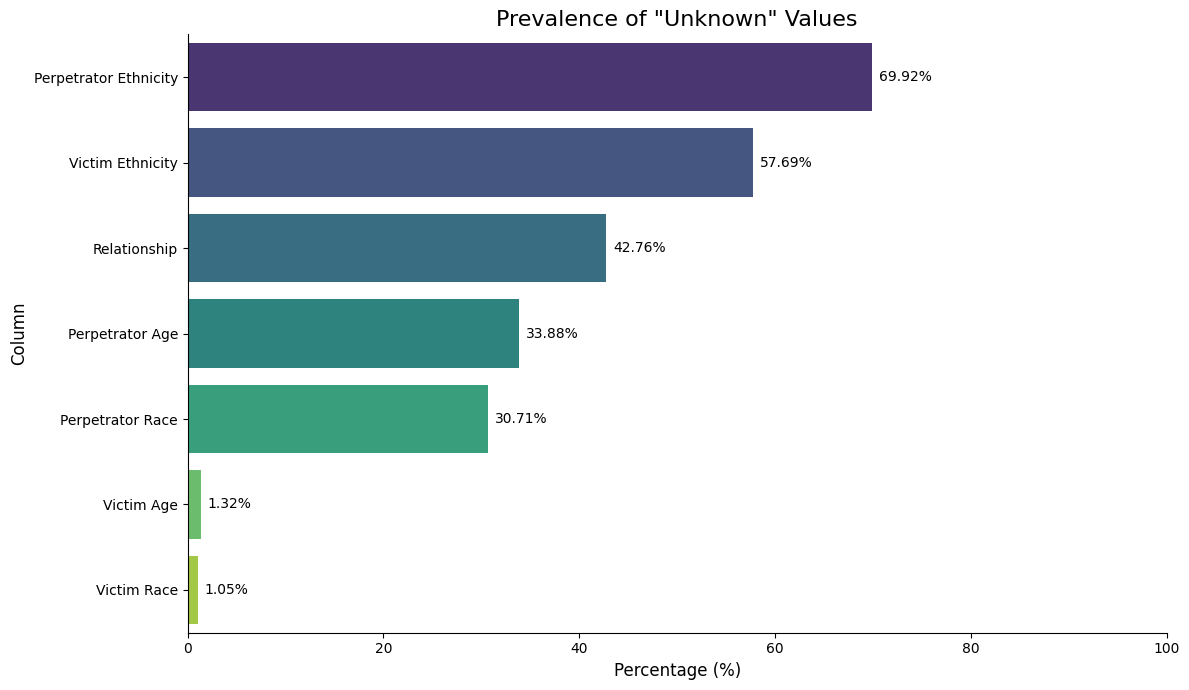

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data collected from previous analysis
unknown_data = {
    'Column': [
        'Relationship',
        'Victim Race',
        'Victim Ethnicity',
        'Perpetrator Race',
        'Perpetrator Ethnicity',
        'Victim Age',
        'Perpetrator Age'
    ],
    'Percentage': [
        42.76, # Relationship
        1.05,  # Victim Race
        57.69, # Victim Ethnicity
        30.71, # Perpetrator Race
        69.92, # Perpetrator Ethnicity
        1.32,  # Victim Age (0 values)
        33.88  # Perpetrator Age (0 values)
    ]
}

df_unknown = pd.DataFrame(unknown_data)

# Sort for better visualization
df_unknown = df_unknown.sort_values(by='Percentage', ascending=False)

plt.figure(figsize=(12, 7))
ax = sns.barplot(x='Percentage', y='Column', data=df_unknown, palette='viridis', hue='Column', legend=False)

# Add percentage labels to the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', padding=5)

plt.title('Prevalence of "Unknown" Values', fontsize=16)
plt.xlabel('Percentage (%)', fontsize=12)
plt.ylabel('Column', fontsize=12)
plt.xlim(0, 100) # Set x-axis limit from 0 to 100 for percentages
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [110]:
markdown_content = '''# US Crime Data Analysis

## Project Overview
This project involves a comprehensive exploratory data analysis (EDA), time series analysis, and spatial mapping of the `US_Crime_DataSet.csv` to uncover patterns, trends, and key insights related to crime incidents across the United States from 1980 to 2014.

## Objectives
-   To perform an in-depth Exploratory Data Analysis (EDA) on the `US_Crime_DataSet.csv` to understand crime patterns and distributions.
-   To identify temporal trends and seasonalities in crime incidents using time series analysis techniques.
-   To visualize the spatial distribution of crime across different US states.
-   To uncover relationships between various factors such as crime type, demographics (victim/perpetrator sex, age, race, ethnicity), weapon used, and crime solvability.
-   To assess data quality, particularly regarding the prevalence of missing or 'Unknown' values, and discuss their implications.
-   To provide actionable insights and recommendations based on the analytical findings.

## Dataset Description
The dataset (`US_Crime_DataSet.csv`) contains detailed information about crime incidents, including:
-   **Record ID**: Unique identifier for each incident.
-   **Agency Information**: Code, Name, Type of the reporting agency.
-   **Location**: City, State of the incident.
-   **Temporal Data**: Year, Month of the incident.
-   **Incident Details**: Crime Type, Crime Solved status, Incident number.
-   **Victim Information**: Sex, Age, Race, Ethnicity, Count.
-   **Perpetrator Information**: Sex, Age, Race, Ethnicity, Count.
-   **Relationship**: Relationship between victim and perpetrator.
-   **Weapon**: Weapon used in the incident.
-   **Record Source**: Source of the record (e.g., FBI).

## Methodology
The analysis was structured into the following phases:
1.  **Data Loading and Initial Inspection**: Loaded the dataset and performed initial checks using `crimes.info()` and `crimes.describe()`.
2.  **Univariate Analysis**: Explored the distribution of individual variables such as `Crime Type`, `Crime Solved`, `Victim Sex`, `Perpetrator Sex`, `Victim Race`, `Perpetrator Race`, `Relationship`, `Weapon`, and age distributions.
3.  **Bivariate Analysis**: Investigated relationships between pairs of variables, including:
    -   Top agencies by crime count.
    -   `Crime Type` vs. `Crime Solved` status.
    -   Sex-to-sex interaction patterns between victims and perpetrators.
    -   Race and ethnicity interaction patterns.
    -   `Victim Age` vs. `Perpetrator Age` relationships.
    -   `Crime Solved` status by `Agency Type`.
    -   Specific analysis on `Female Perpetrator` and `Male Victim` relationships.
4.  **Spatial Mapping**: Visualized crime distribution across US states using choropleth maps for total incidents, victim counts, perpetrator counts, and unsolved crimes.
5.  **Time Series Analysis**: Examined temporal trends of crime incidents, including:
    -   Yearly and monthly incident counts.
    -   Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) to identify temporal dependencies.
    -   Trends in specific crime types and solved/unsolved crimes over time.
6.  **Data Quality Assessment**: Evaluated the prevalence of 'Unknown' or '0' values in critical demographic and relationship columns and discussed their implications.
7.  **Unnoticed Observations**: Explored `Crime Type` vs. `Weapon` usage and `Relationship` vs. `Crime Solved` status for deeper insights.

## Key Findings

### 1. Univariate Analysis
-   **Crime Type:** 'Murder or Manslaughter' accounts for ~98.6% of incidents.
-   **Crime Solved:** ~69.8% of crimes are solved, ~30.2% unsolved.
-   **Victim/Perpetrator Sex:** Both victims (~75.1%) and perpetrators (~74.7%) are predominantly male.
-   **Race and Ethnicity:** 'White' is the most common race for victims (~46.8%) and perpetrators (~42.4%). 'Unknown' is the largest ethnicity category for both (~68.1% for victims, ~69.9% for perpetrators).
-   **Relationship:** 'Unknown' is the most frequent relationship (~43.2%), followed by 'Acquaintance' (~19.9%) and 'Stranger' (~15.3%).
-   **Weapon Used:** 'Handgun' is the most common weapon (~49.7%), followed by 'Knife' (~14.9%) and 'Blunt Object' (~10.5%).
-   **Age Distribution:** Both victim and perpetrator ages are concentrated in the 21-30 age group.

### 2. Bivariate Analysis
-   **Top Agencies:** Chicago, Houston, and Detroit Municipal Police recorded the highest crime counts.
-   **Crime Type vs. Solved:** 'Manslaughter by Negligence' has a very high solved rate (~95.7%), while 'Murder or Manslaughter' has a ~69.8% solved rate.
-   **Sex Interaction:** Male perpetrators are largely involved in crimes against male victims (~75.1%), while female perpetrators primarily target male victims (~77.5%).
-   **Relationship (Female Perpetrator & Male Victim):** The most frequent relationships are Husband (22.81%), Boyfriend (18.69%), Acquaintance (16.52%), Son (9.91%), and Unknown (9.45%).
-   **Race/Ethnicity Interaction:** Strong patterns of intra-racial and intra-ethnic crimes were observed.
-   **Victim Age vs. Perpetrator Age:** Perpetrators often target victims in similar age groups.
-   **Crime Solved by Agency Type:** 'State Police' (~82.3%) and 'Tribal Police' (~92.6%) show the highest solved rates.

### 3. Spatial Mapping
-   **Geographical Hotspots:** California, Texas, and Florida consistently show the highest crime incidents, victim counts, and perpetrator counts.
-   **Unsolved Crimes by State:** California, New York, and Texas have the highest numbers of unsolved crimes.

### 4. Time Series Analysis
-   **Overall Trends (1980-2014):** A general decreasing trend in annual crime incidents was observed.
-   **Autocorrelation:** Significant autocorrelation was found in overall incidents, specific crime types, and victim/perpetrator counts, suggesting temporal dependencies.
-   **Seasonal Patterns:** Monthly incident heatmaps revealed consistent seasonal crime patterns.
-   **Crime Type Trends:** 'Murder or Manslaughter' incidents decreased over time, mirroring the overall trend.
-   **Solved vs. Unsolved Trends:** Both solved and unsolved crime counts follow the overall decreasing trend.

### 5. Unnoticed Observations (Data Quality & Specific Relationships)
-   **Significant Data Gaps**: There is a very high percentage of 'Unknown' values in critical demographic columns: `Perpetrator Ethnicity` (69.92%), `Victim Ethnicity` (57.69%), `Relationship` (42.76%), and `Perpetrator Race` (30.71%). This limits detailed demographic analysis.
-   **Missing Perpetrator Age Data**: A substantial 33.88% of `Perpetrator Age` entries are '0', likely indicating missing data, which can skew age-related analyses.
-   **Weapon Usage by Crime Type**: The distribution of weapon types varies significantly across `Crime Type`, indicating specific associations (e.g., handguns prevalent in 'Murder or Manslaughter').
-   **Relationship vs. Crime Solved**: The type of relationship between victim and perpetrator impacts crime solvability, with some relationships showing higher or lower resolution rates (e.g., `Employer` and `Stepmother` have 100% solved rates, while `Unknown` has 64.9%).

## Insights and Recommendations
-   **Data Quality**: The high percentage of 'Unknown' values in key demographic fields suggests a need for improved data collection practices or a robust strategy for handling missing data (e.g., advanced imputation or careful exclusion) in future analyses or predictive modeling efforts.
-   **Predictive Modeling Potential**: While feasible, predictive modeling would require significant preprocessing to address the 'Unknown' values. Columns like `Crime Solved`, `Crime Type`, `Weapon`, and geographical/temporal features offer good potential as targets or predictors.
-   **Targeted Investigations**: The analysis of `Relationship` influencing `Crime Solved` status can help agencies understand which cases might require more resources or have specific challenges during investigation. For example, cases involving `Unknown` relationships tend to have lower solved rates.
-   **Further Research**: Investigating the context behind high 'Unknown' rates and the specific dynamics within intimate partner and familial violence (especially for female perpetrators and male victims) could yield deeper sociological insights.

## Technical Stack
-   **Python** (Programming Language)
-   **Pandas** (Data Manipulation and Analysis)
-   **NumPy** (Numerical Operations)
-   **Matplotlib** (Static Visualizations)
-   **Seaborn** (Enhanced Statistical Visualizations)
-   **Plotly Express** (Interactive Visualizations, especially for geospatial data and time series)
-   **Statsmodels** (Time Series Analysis: ACF, PACF)

## How to Run the Project
1.  **Clone the Repository**:
    ```bash
    git clone <your-repository-link>
    cd <your-repository-name>
    ```
2.  **Install Dependencies**:
    ```bash
    pip install pandas numpy matplotlib seaborn plotly statsmodels
    ```
3.  **Download the Dataset**: Ensure `US_Crime_DataSet.csv` is placed in the appropriate directory (e.g., `/content/drive/MyDrive/DA/` as used in the notebook, or adjust the path in the code).
4.  **Run the Jupyter Notebook**:
    Open `your_notebook_name.ipynb` in a Jupyter environment (e.g., Google Colab, Jupyter Lab, Jupyter Notebook) and execute the cells sequentially.

## Future Work
-   Develop predictive models for crime solvability or crime type classification.
-   Conduct more in-depth causal analysis on identified trends.
-   Explore advanced time series forecasting techniques.
-   Investigate specific geographic regions with high crime rates more thoroughly.
'''

with open('README.md', 'w') as f:
    f.write(markdown_content)

print("README.md has been created in your current working directory.")
print("You can download it from the 'Files' section in Colab (left sidebar).")

README.md has been created in your current working directory.
You can download it from the 'Files' section in Colab (left sidebar).


#Univariate Analysis

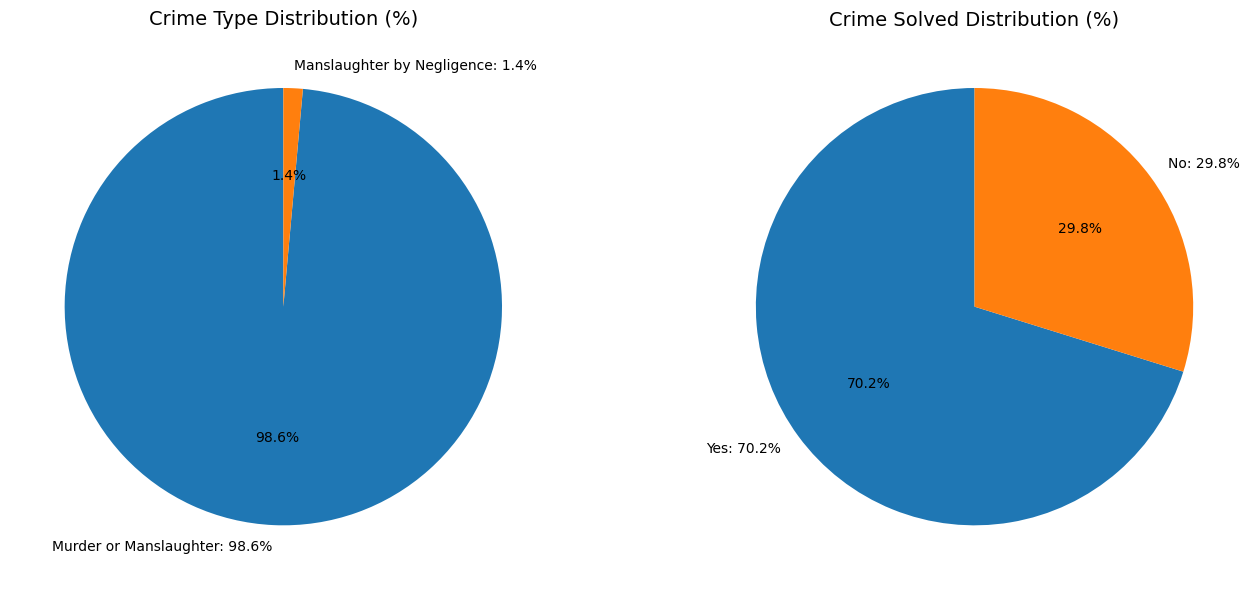

In [51]:
import matplotlib.pyplot as plt

cols = ['Crime Type', 'Crime Solved']

# Create subplot: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, col in zip(axes, cols):
    counts = crimes[col].value_counts(dropna=False)
    percentages = (counts / counts.sum()) * 100

    ax.pie(
        percentages,
        labels=[f"{label}: {pct:.1f}%" for label, pct in zip(percentages.index, percentages)],
        autopct="%.1f%%",
        startangle=90
    )
    ax.set_title(f"{col} Distribution (%)", fontsize=14)

plt.tight_layout()
plt.show()

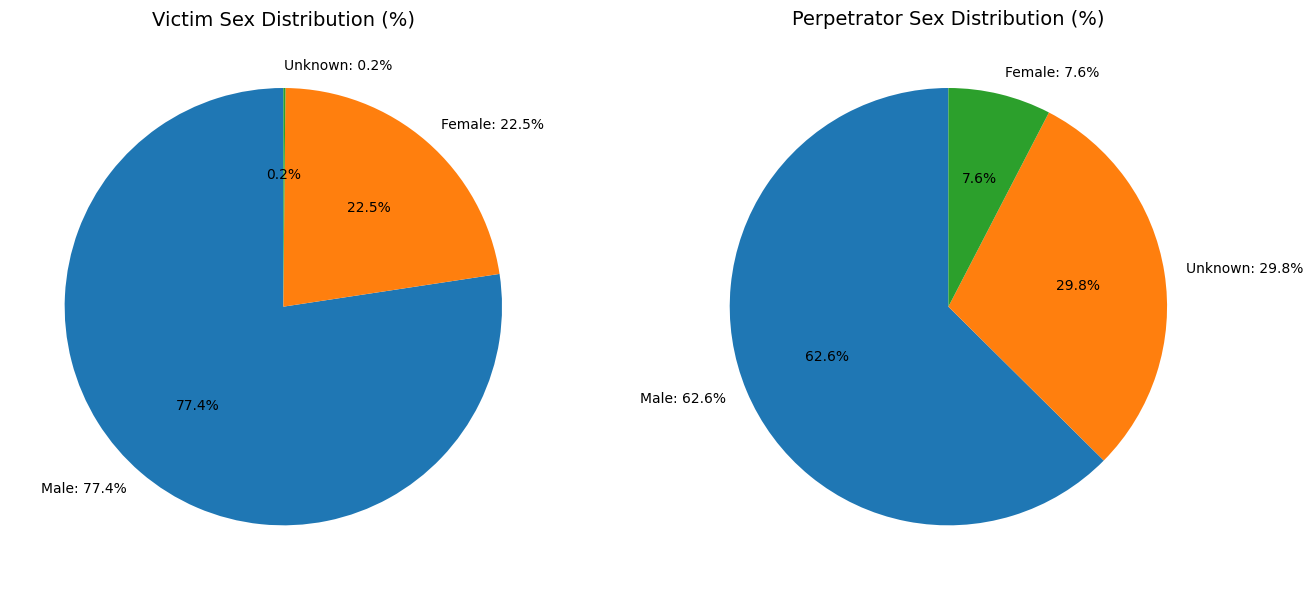

In [52]:
import matplotlib.pyplot as plt

cols = ['Victim Sex', 'Perpetrator Sex']

# Create subplot: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, col in zip(axes, cols):
    counts = crimes[col].value_counts(dropna=False)
    percentages = (counts / counts.sum()) * 100

    ax.pie(
        percentages,
        labels=[f"{label}: {pct:.1f}%" for label, pct in zip(percentages.index, percentages)],
        autopct="%.1f%%",
        startangle=90
    )
    ax.set_title(f"{col} Distribution (%)", fontsize=14)

plt.tight_layout()
plt.show()

/tmp/ipython-input-2396474998.py:31: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipython-input-2396474998.py:31: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipython-input-2396474998.py:31: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipython-input-2396474998.py:31: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



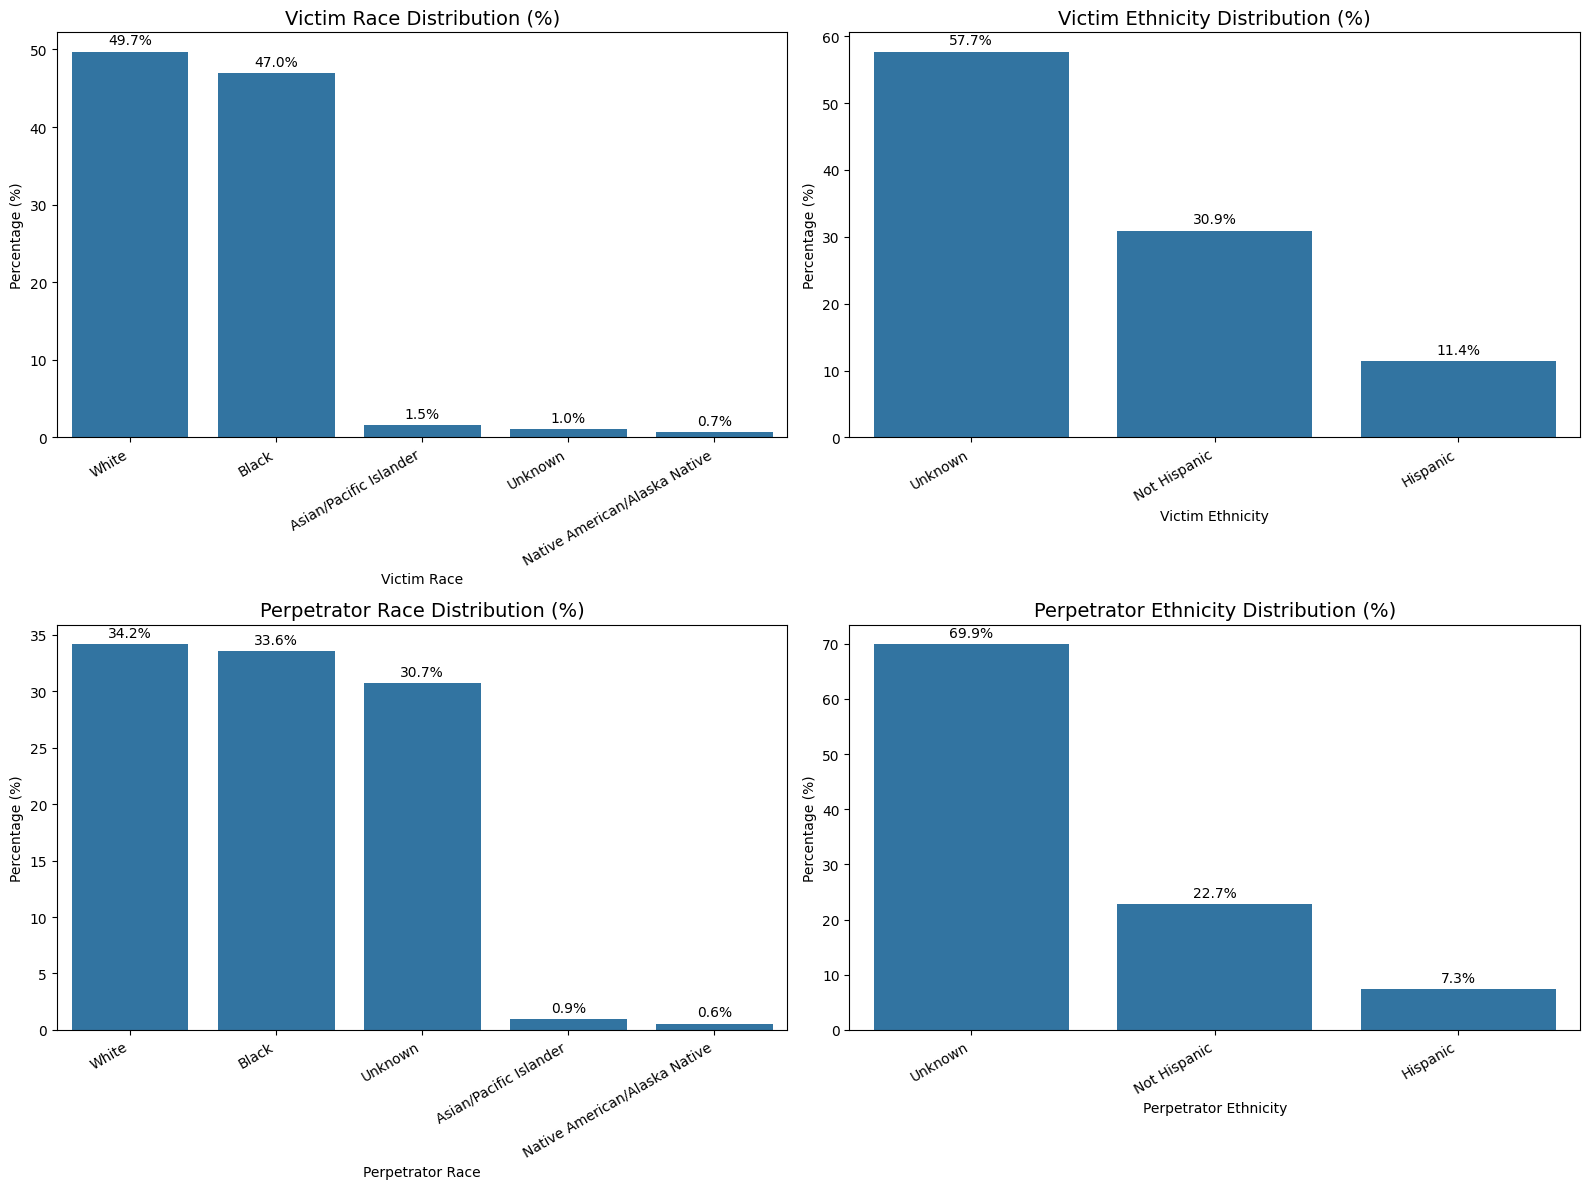

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Columns to plot
cols = ['Victim Race', 'Victim Ethnicity',
        'Perpetrator Race', 'Perpetrator Ethnicity']

# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Flatten axes for easy looping
axes = axes.flatten()

for ax, col in zip(axes, cols):
    # Count and percentage
    counts = crimes[col].value_counts(dropna=False)
    percentages = (counts / counts.sum()) * 100

    # Convert to DataFrame for seaborn
    df_plot = percentages.reset_index()
    df_plot.columns = [col, 'Percent']

    sns.barplot(
        data=df_plot,
        x=col,
        y='Percent',
        ax=ax
    )

    # Rotate labels for readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

    # Add bar labels
    for container in ax.containers:
        ax.bar_label(container, fmt="%.1f%%", padding=3)

    ax.set_title(f"{col} Distribution (%)", fontsize=14)
    ax.set_ylabel("Percentage (%)")

plt.tight_layout()
plt.show();

/tmp/ipython-input-1853021547.py:53: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipython-input-1853021547.py:76: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



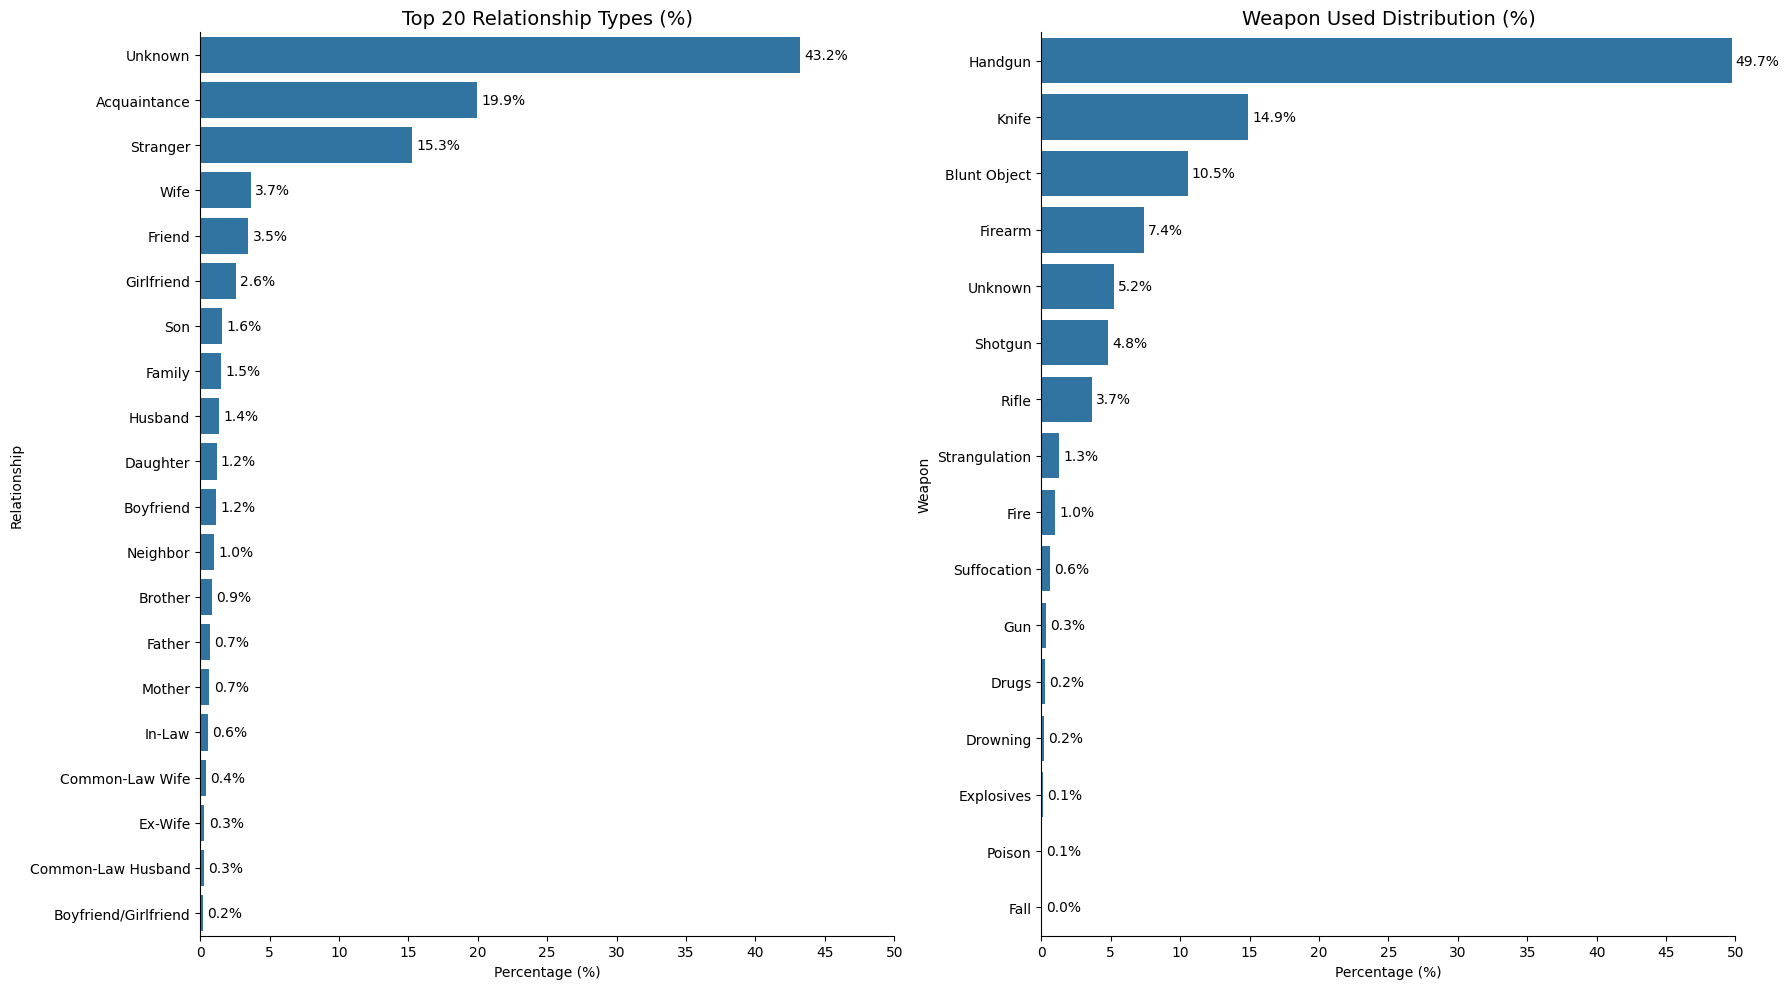

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =============================
# 1. Relationship (Top 20 Only)

# =============================
rel_counts = crimes["Relationship"].value_counts(dropna=False).head(20)
rel_percent = (rel_counts / rel_counts.sum()) * 100

df_rel = rel_percent.reset_index()
df_rel.columns = ["Relationship", "Percent"]

# =============================
# 2. Weapon (All)
# =============================
weapon_counts = crimes["Weapon"].value_counts(dropna=False)
weapon_percent = (weapon_counts / weapon_counts.sum()) * 100

df_weapon = weapon_percent.reset_index()
df_weapon.columns = ["Weapon", "Percent"]

# =============================
# Subplots — 1 row × 2 columns
# =============================
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# ---- LEFT: Relationship ----
sns.barplot(
    data=df_rel,
    y="Relationship",
    x="Percent",
    ax=axes[0],
    orient="h"
)

# Label on bars
for container in axes[0].containers:
    axes[0].bar_label(container, fmt="%.1f%%", padding=3)

# Axis config
axes[0].set_xticks(np.arange(0, 51, 5))
axes[0].set_xlim(0, 50)

# Remove top & left spines
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)

axes[0].set_title("Top 20 Relationship Types (%)", fontsize=14)
axes[0].set_xlabel("Percentage (%)")
axes[0].set_ylabel("Relationship")
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)

# ---- RIGHT: Weapon ----
sns.barplot(
    data=df_weapon,
    y="Weapon",
    x="Percent",
    ax=axes[1],
    orient="h"
)

for container in axes[1].containers:
    axes[1].bar_label(container, fmt="%.1f%%", padding=3)

axes[1].set_xticks(np.arange(0, 51, 5))
axes[1].set_xlim(0, 50)

axes[1].spines["top"].set_visible(False)
axes[1].spines["right"].set_visible(False)

axes[1].set_title("Weapon Used Distribution (%)", fontsize=14)
axes[1].set_xlabel("Percentage (%)")
axes[1].set_ylabel("Weapon")
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

In [55]:
numcols = crimes.select_dtypes(exclude=["category"]).columns
crimes[numcols].describe()

,Record ID,Year,Incident,Victim Age,Victim Count,Perpetrator Count
count,"638,454.00","638,454.00","638,454.00","638,454.00","638,454.00","638,454.00"
mean,"319,227.50","1,995.80",22.97,35.03,0.12,0.19
std,"184,305.94",9.93,92.15,41.63,0.54,0.59
min,1.00,"1,980.00",0.00,0.00,0.00,0.00
25%,"159,614.25","1,987.00",1.00,22.00,0.00,0.00
50%,"319,227.50","1,995.00",2.00,30.00,0.00,0.00
75%,"478,840.75","2,004.00",10.00,42.00,0.00,0.00
max,"638,454.00","2,014.00",999.00,998.00,10.00,10.00


In [56]:
crimes[numcols].quantile(np.arange(0.0, 1.1, 0.1),numeric_only=True)

,Record ID,Year,Incident,Victim Age,Victim Count,Perpetrator Count
0.00,1.00,"1,980.00",0.00,0.00,0.00,0.00
0.10,"63,846.30","1,982.00",1.00,17.00,0.00,0.00
0.20,"127,691.60","1,986.00",1.00,21.00,0.00,0.00
0.30,"191,536.90","1,989.00",1.00,23.00,0.00,0.00
0.40,"255,382.20","1,992.00",1.00,26.00,0.00,0.00
0.50,"319,227.50","1,995.00",2.00,30.00,0.00,0.00
0.60,"383,072.80","1,998.00",4.00,34.00,0.00,0.00
0.70,"446,918.10","2,002.00",7.00,39.00,0.00,0.00
0.80,"510,763.40","2,006.00",14.00,45.00,0.00,0.00
0.90,"574,608.70","2,010.00",36.00,57.00,0.00,1.00


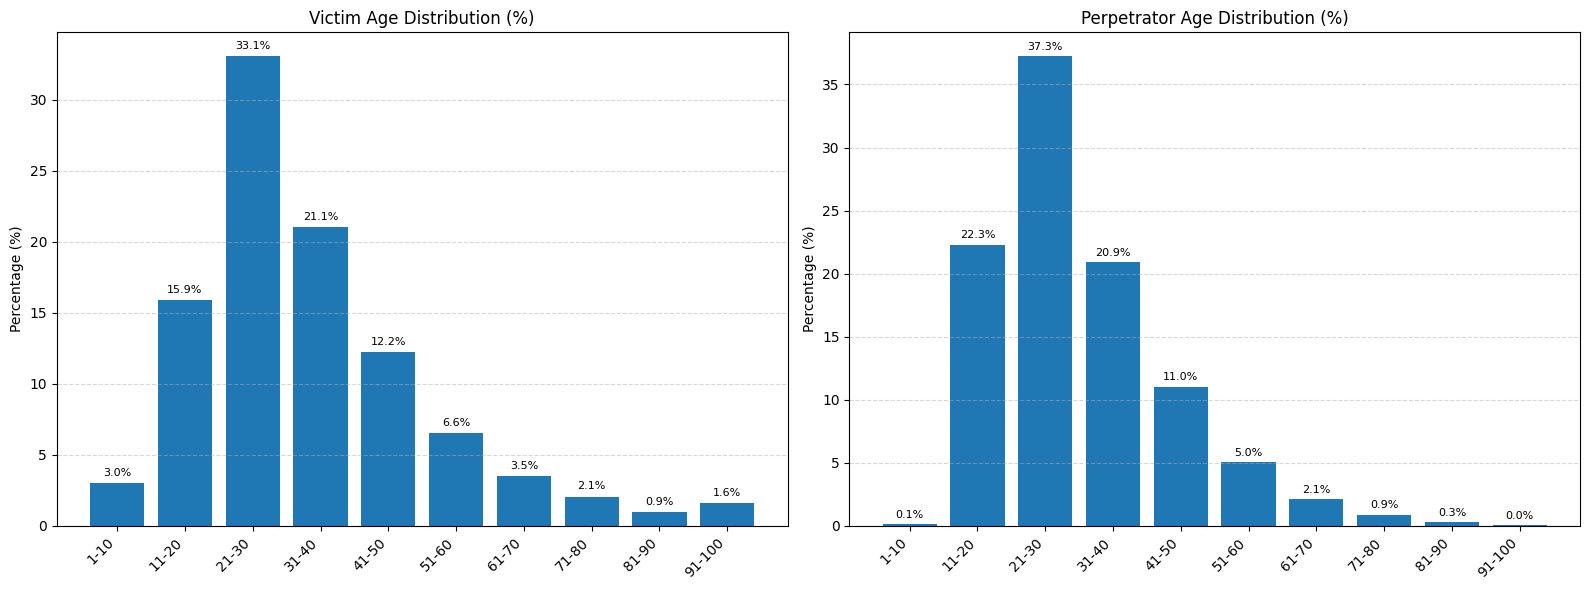

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- CLEAN DATA ---- #
# Convert 'Perpetrator Age' to numeric, coercing errors to NaN
crimes['Perpetrator Age'] = pd.to_numeric(crimes['Perpetrator Age'], errors='coerce')

# Drop rows where 'Perpetrator Age' is NaN (due to coercion)
df_clean = crimes.dropna(subset=['Perpetrator Age']).copy()

# Filter for ages within a reasonable range (0-100 for both victim and perpetrator)
df_clean = df_clean[(df_clean['Victim Age'] <= 100) & (df_clean['Perpetrator Age'] <= 100)]

# ---- AGE BIN SETUP ---- #
bins = range(1, 101, 10)
labels = [f"{i}-{i+9}" for i in bins]
cut_bins = [1] + [i + 9 for i in bins]  # e.g., 1–10, 11–20, ...

# ---- FUNCTION FOR AGE PROCESSING ---- #
def get_age_percentages(df, column):
    binned = pd.cut(df[column], bins=cut_bins, labels=labels, include_lowest=True)
    dummies = pd.get_dummies(binned).sort_index(axis=1)
    return dummies.sum() / dummies.sum().sum() * 100

# Compute percentages
victim_percent = get_age_percentages(df_clean, 'Victim Age')
perp_percent = get_age_percentages(df_clean, 'Perpetrator Age')

# ---- PLOTTING ---- #
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

def plot_age(ax, data, title):
    ax.bar(labels, data)
    # Add text labels
    for i, v in enumerate(data):
        ax.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontsize=8)
    ax.set_title(title)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel("Percentage (%)")
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plot_age(ax[0], victim_percent, "Victim Age Distribution (%)")
plot_age(ax[1], perp_percent, "Perpetrator Age Distribution (%)")

plt.tight_layout()
plt.show()

#Bivariate Analysis

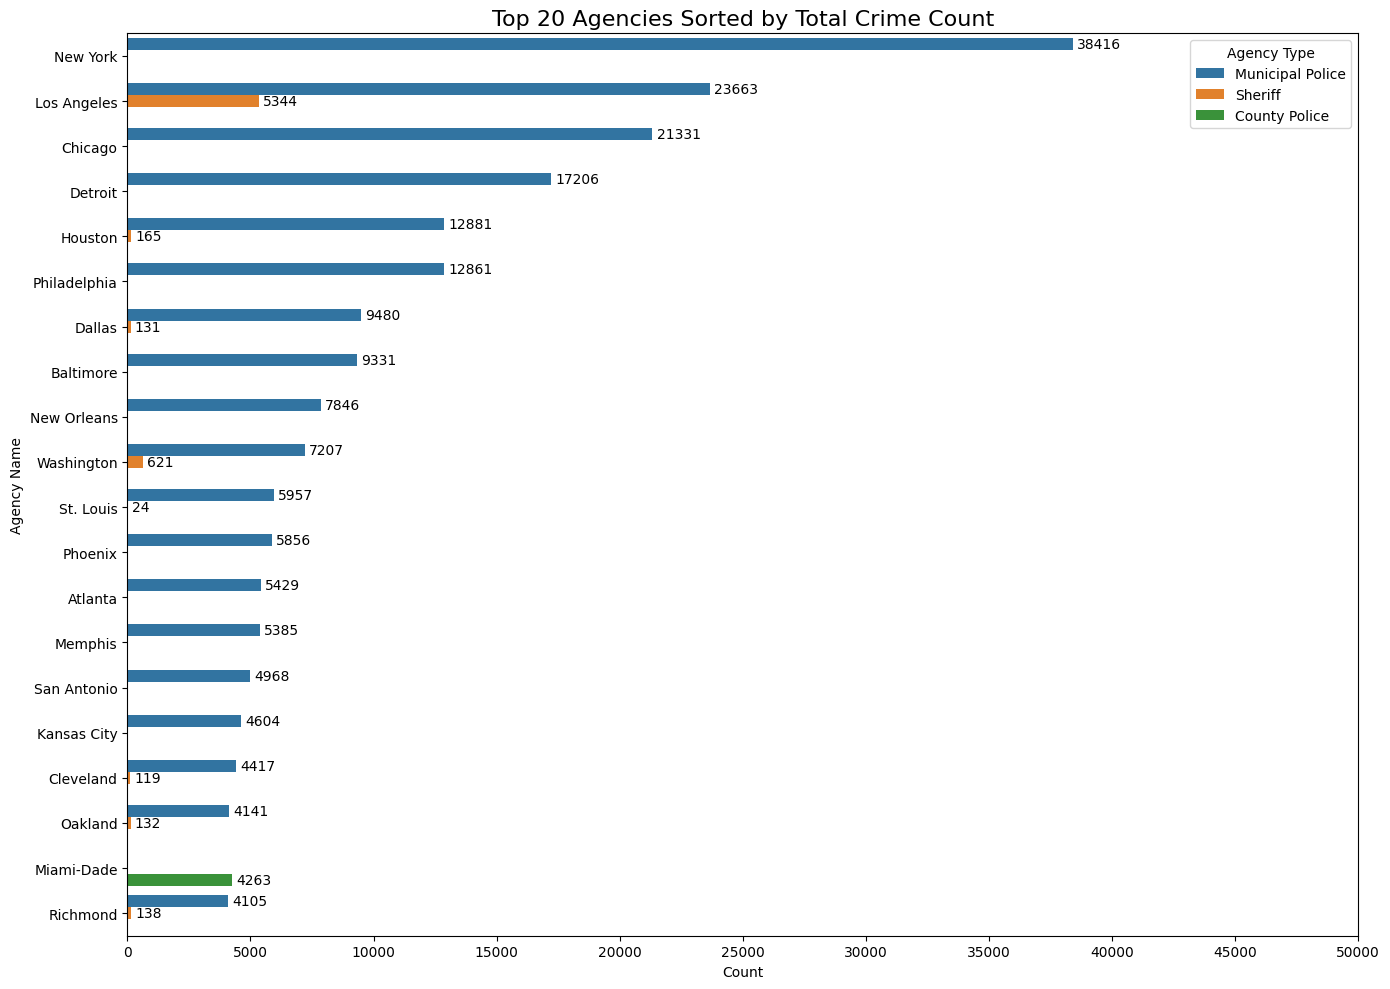

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Group by Agency Name + Agency Type
agency_counts = crimes.groupby(['Agency Name', 'Agency Type']).size().reset_index(name='Count')

# 2. Top 20 agencies
top20 = (
    agency_counts.groupby('Agency Name')['Count']
    .sum()
    .nlargest(20)
    .index
)
agency_counts = agency_counts[agency_counts['Agency Name'].isin(top20)]

# 3. Sort agencies by total count (DESCENDING)
agency_order = (
    agency_counts.groupby('Agency Name')['Count']
    .sum()
    .sort_values(ascending=False)
    .index
)
agency_counts["Agency Name"] = pd.Categorical(
    agency_counts["Agency Name"],
    categories=agency_order,
    ordered=True
)

# 4. Plot (horizontal)
plt.figure(figsize=(14, 10))
ax = sns.barplot(
    data=agency_counts,
    y='Agency Name',
    x='Count',
    hue='Agency Type',
    orient='h'
)

# 5. Add labels
for container in ax.containers:
    ax.bar_label(container, padding=3)

# 6. X-axis from 0 to 50k with steps of 5k
plt.xlim(0, 50000)
plt.xticks(np.arange(0, 50001, 5000))

plt.title("Top 20 Agencies Sorted by Total Crime Count", fontsize=16)
plt.xlabel("Count")
plt.ylabel("Agency Name")

plt.tight_layout()
plt.show()

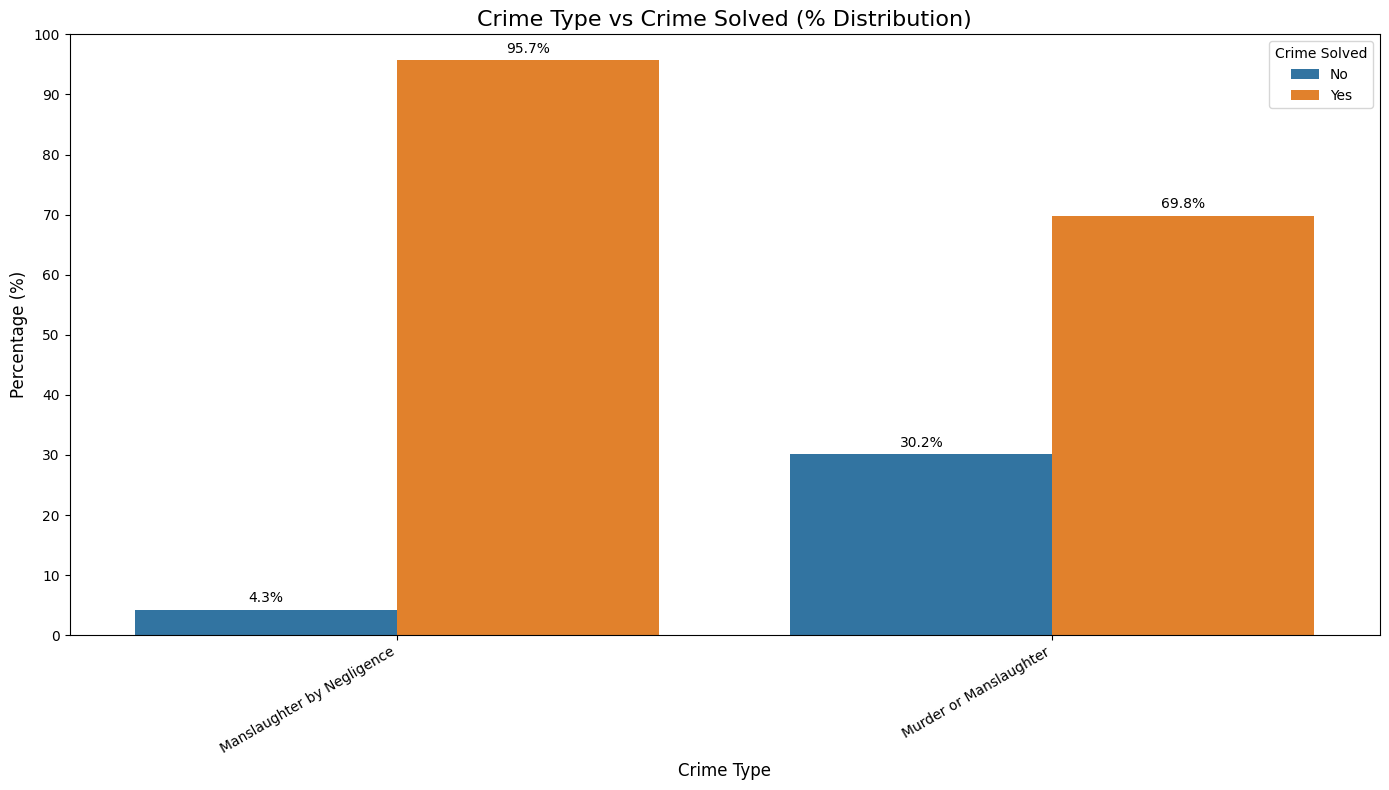

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Compute counts
crime_counts = crimes.groupby(['Crime Type', 'Crime Solved']).size().reset_index(name='Count')

# 2. Convert counts to percent within each Crime Type
crime_counts['Percent'] = (
    crime_counts.groupby('Crime Type')['Count']
    .apply(lambda x: (x / x.sum()) * 100)
    .reset_index(drop=True)
)

# 3. Plot (vertical)
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=crime_counts,
    x='Crime Type',
    y='Percent',
    hue='Crime Solved'
)

# 4. Add % labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", padding=3)

# 5. Y-axis: 0–100 with ticks every 10
plt.ylim(0, 100)
plt.yticks(np.arange(0, 101, 10))

# 6. Formatting
plt.xticks(rotation=30, ha='right')
plt.title("Crime Type vs Crime Solved (% Distribution)", fontsize=16)
plt.xlabel("Crime Type", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)

plt.tight_layout()
plt.show()

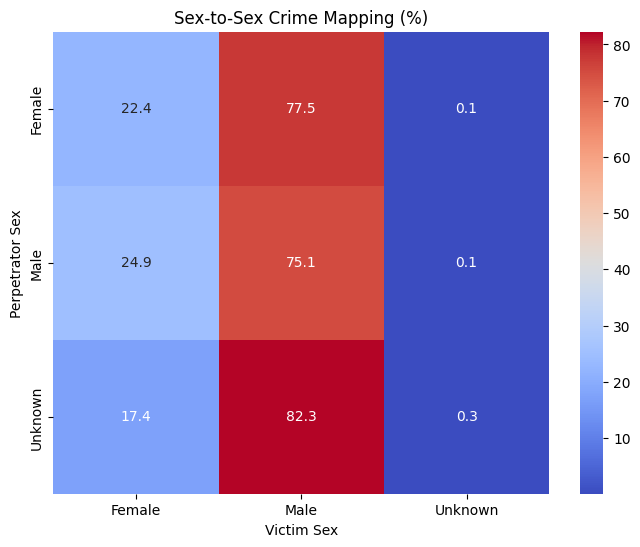

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a cross-tabulation
sex_matrix = pd.crosstab(crimes['Perpetrator Sex'], crimes['Victim Sex'], normalize='index') * 100

plt.figure(figsize=(8, 6))
sns.heatmap(sex_matrix, annot=True, fmt='.1f', cmap='coolwarm')
plt.title('Sex-to-Sex Crime Mapping (%)')
plt.xlabel('Victim Sex')
plt.ylabel('Perpetrator Sex')
plt.show()

In [95]:
female_perp_male_victim = crimes[
    (crimes['Perpetrator Sex'] == 'Female') &
    (crimes['Victim Sex'] == 'Male')
]

In [96]:
relationship_counts = female_perp_male_victim['Relationship'].value_counts()
relationship_percentages = (female_perp_male_victim['Relationship'].value_counts(normalize=True) * 100)

relationship_distribution = pd.DataFrame({
    'Count': relationship_counts,
    'Percentage': relationship_percentages
}).reset_index()
relationship_distribution.columns = ['Relationship', 'Count', 'Percentage']

display(relationship_distribution)

,Relationship,Count,Percentage
0,Husband,8585,22.81
1,Boyfriend,7034,18.69
2,Acquaintance,6217,16.52
3,Son,3728,9.91
4,Unknown,3557,9.45
5,Stranger,2230,5.93
6,Common-Law Husband,1890,5.02
7,Friend,1107,2.94
8,Family,715,1.90
9,Ex-Husband,584,1.55


/tmp/ipython-input-374960730.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




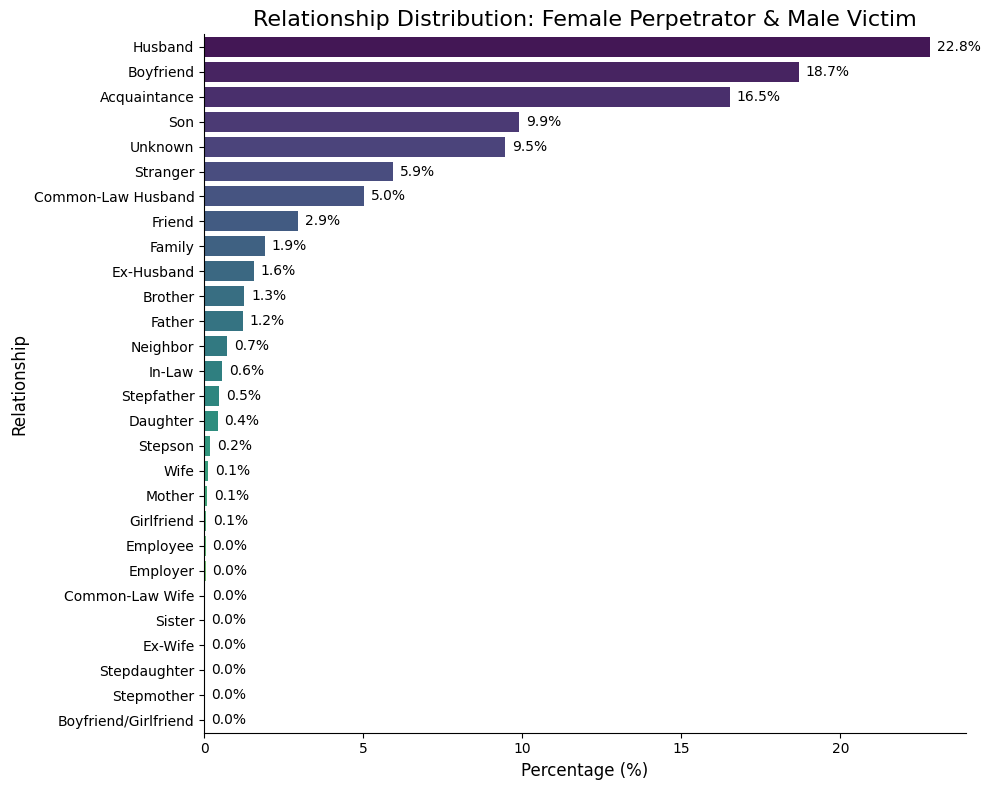

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Create a bar plot
plt.figure(figsize=(10, 8))
ax = sns.barplot(
    data=relationship_distribution.sort_values(by='Percentage', ascending=False),
    x='Percentage',
    y='Relationship',
    orient='h', # horizontal bar plot
    palette='viridis'
)

# 2. Set the title of the plot
plt.title('Relationship Distribution: Female Perpetrator & Male Victim', fontsize=16)

# 3. Label the x-axis as 'Percentage (%)' and the y-axis as 'Relationship'
plt.xlabel('Percentage (%)', fontsize=12)
plt.ylabel('Relationship', fontsize=12)

# 4. Add percentage labels to each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=5)

# Remove top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 5. Ensure the plot has a tight layout and is displayed.
plt.tight_layout()
plt.show()

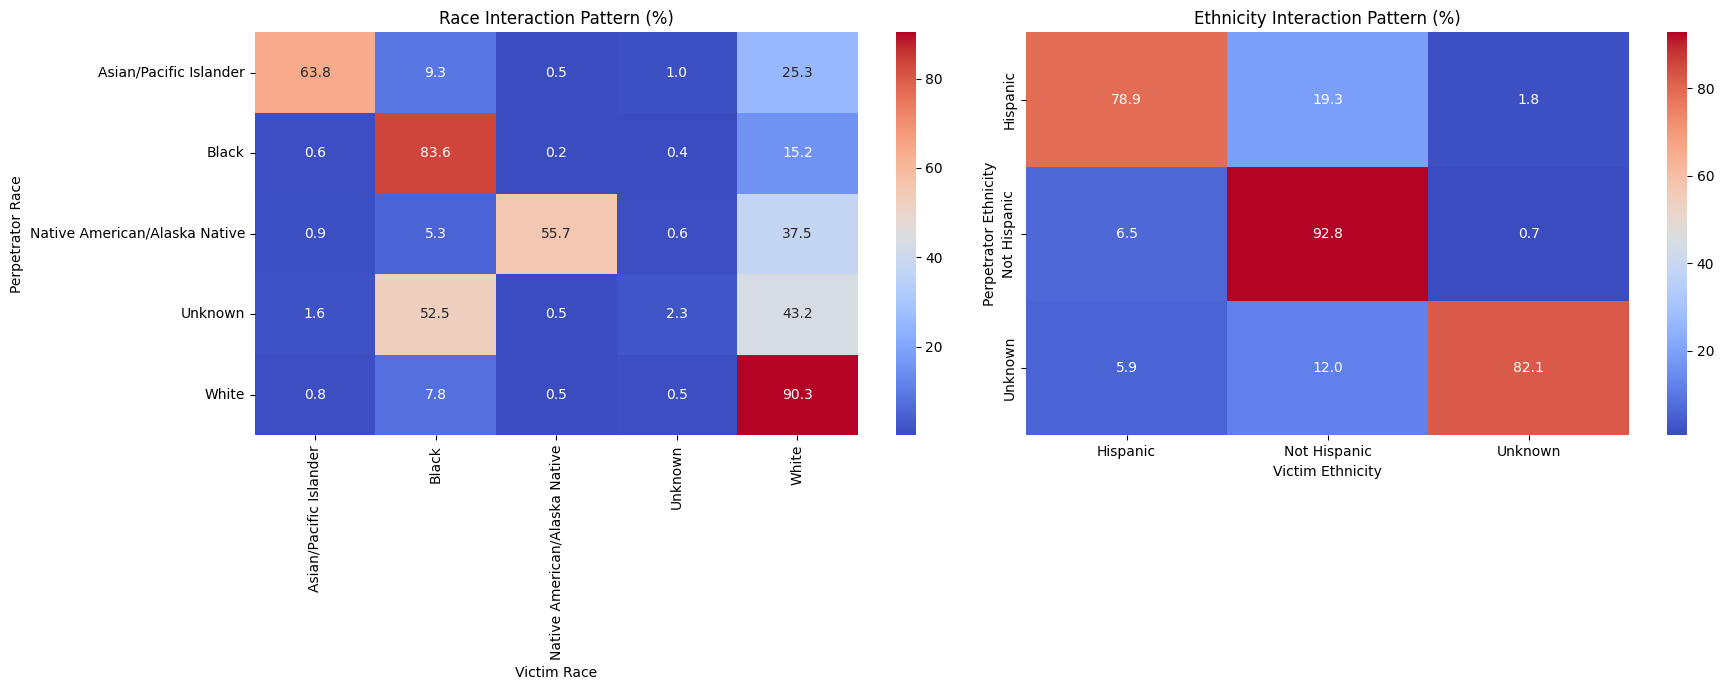

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# ----- RACE MATRIX -----
race_matrix = pd.crosstab(
    crimes['Perpetrator Race'],
    crimes['Victim Race'],
    normalize='index'
) * 100

# ----- ETHNICITY MATRIX -----
ethnicity_matrix = pd.crosstab(
    crimes['Perpetrator Ethnicity'],
    crimes['Victim Ethnicity'],
    normalize='index'
) * 100

# ----- PLOT BOTH SIDE BY SIDE -----
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Left plot (Race)
sns.heatmap(
    race_matrix,
    annot=True,
    fmt='.1f',
    cmap='coolwarm',
    ax=axes[0]
)
axes[0].set_title('Race Interaction Pattern (%)')
axes[0].set_xlabel('Victim Race')
axes[0].set_ylabel('Perpetrator Race')

# Right plot (Ethnicity)
sns.heatmap(
    ethnicity_matrix,
    annot=True,
    fmt='.1f',
    cmap='coolwarm',
    ax=axes[1]
)
axes[1].set_title('Ethnicity Interaction Pattern (%)')
axes[1].set_xlabel('Victim Ethnicity')
axes[1].set_ylabel('Perpetrator Ethnicity')

plt.tight_layout()
plt.show()

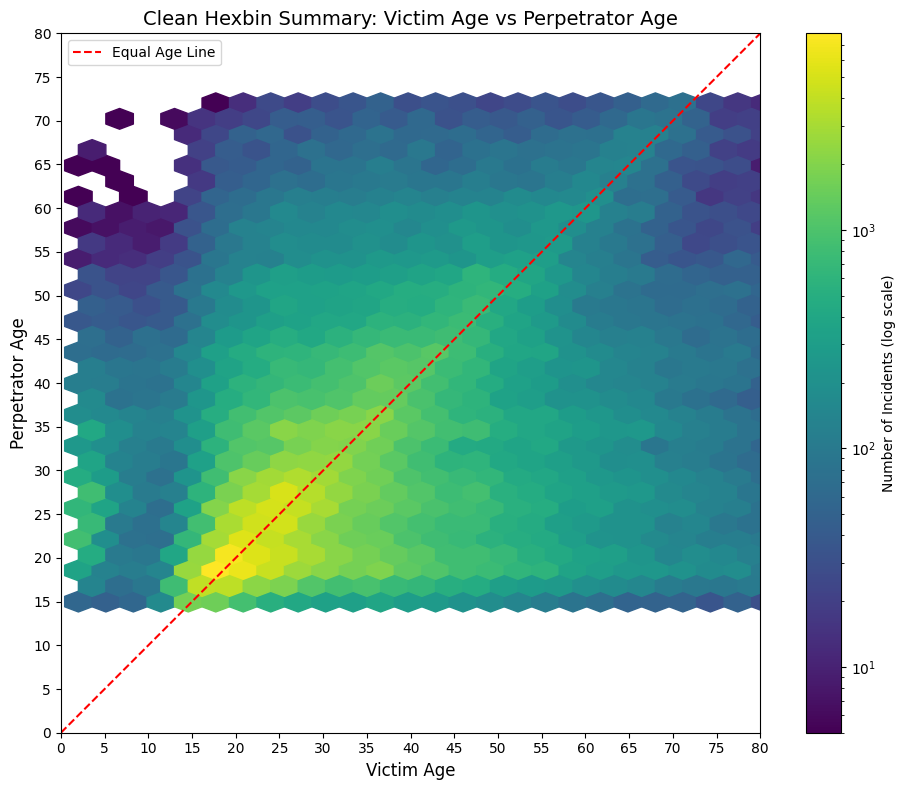

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# -----------------------------------------
# 1. CLEAN THE DATA PROPERLY
# -----------------------------------------

df = crimes.copy()

# Remove missing ages
df = df[df['Victim Age'].notna() & df['Perpetrator Age'].notna()]

# Convert to numeric (in case some ages are strings)
df['Victim Age'] = pd.to_numeric(df['Victim Age'], errors='coerce')
df['Perpetrator Age'] = pd.to_numeric(df['Perpetrator Age'], errors='coerce')

# Remove newly created NaNs
df = df.dropna(subset=['Victim Age', 'Perpetrator Age'])

# Remove unrealistic outliers (<1 or >100)
df = df[(df['Victim Age'].between(1, 100)) &
        (df['Perpetrator Age'].between(1, 100))]

# OPTIONAL but recommended:
# Remove extremely rare ages (noise)
df = df[(df['Victim Age'] > df['Victim Age'].quantile(0.01)) &
        (df['Victim Age'] < df['Victim Age'].quantile(0.99))]
df = df[(df['Perpetrator Age'] > df['Perpetrator Age'].quantile(0.01)) &
        (df['Perpetrator Age'] < df['Perpetrator Age'].quantile(0.99))]

# -----------------------------------------
# 2. CREATE CLEAN HEXBIN PLOT
# -----------------------------------------

plt.figure(figsize=(10, 8))

hb = plt.hexbin(
    df['Victim Age'],
    df['Perpetrator Age'],
    gridsize=28,          # Balanced density resolution
    mincnt=5,             # Remove random noise hexagons
    cmap='viridis',
    bins='log'            # Log scale to prevent overpowering high-density bins
)

# Plot the equal-age line
age_min, age_max = 0, 80
plt.plot([age_min, age_max], [age_min, age_max],
         linestyle='--', color='red', linewidth=1.5, label='Equal Age Line')

# -----------------------------------------
# 3. IMPROVE AXES & VISUALS
# -----------------------------------------

plt.xlim(0, 80)
plt.ylim(0, 80)

plt.xticks(np.arange(0, 81, 5))
plt.yticks(np.arange(0, 81, 5))

plt.xlabel("Victim Age", fontsize=12)
plt.ylabel("Perpetrator Age", fontsize=12)
plt.title("Clean Hexbin Summary: Victim Age vs Perpetrator Age", fontsize=14)

plt.colorbar(hb, label="Number of Incidents (log scale)")

plt.legend()
plt.grid(False)

# Maintain proper shape for accurate interpretation
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

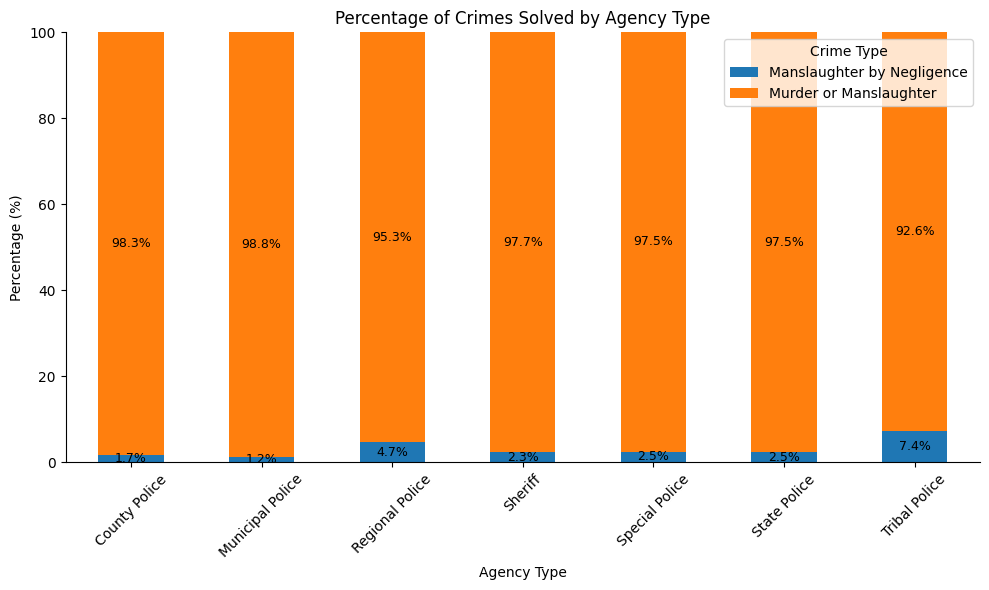

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------
# Create percentage table
# -------------------------------------------------
agency_solved = (
    pd.crosstab(
        crimes['Agency Type'],
        crimes['Crime Type'],
        normalize='index'
    ) * 100
)

# -------------------------------------------------
# Plot
# -------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

agency_solved.plot(
    kind='bar',
    stacked=True,
    ax=ax
)

# -------------------------------------------------
# Add percentage labels to each stack
# -------------------------------------------------
for container in ax.containers:
    ax.bar_label(
        container,
        fmt='%.1f%%',
        label_type='center',
        fontsize=9
    )

# -------------------------------------------------
# Formatting
# -------------------------------------------------
ax.set_title('Percentage of Crimes Solved by Agency Type')
ax.set_xlabel('Agency Type')
ax.set_ylabel('Percentage (%)')
ax.set_ylim(0, 100)
ax.legend(title='Crime Type')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

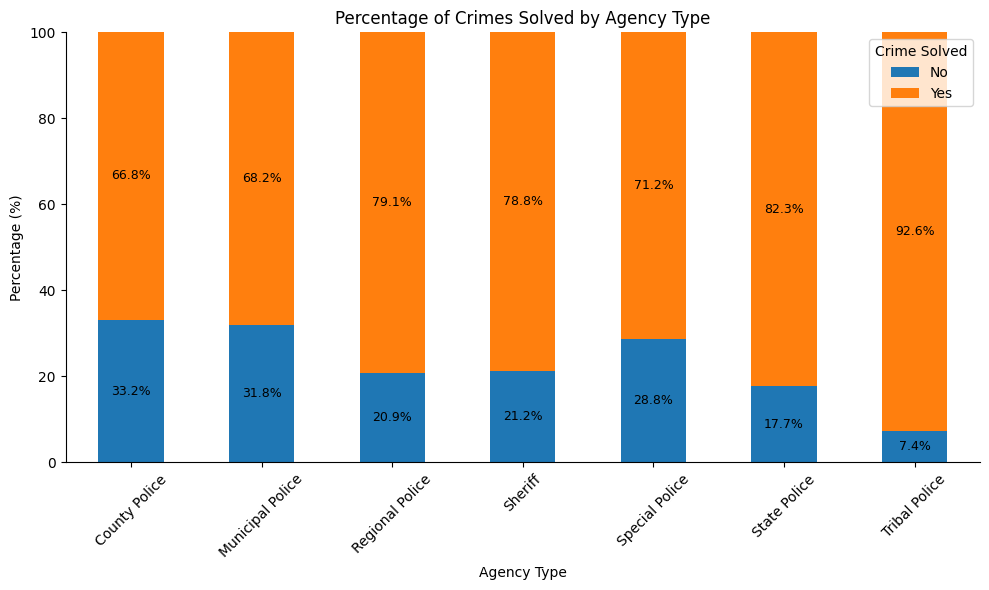

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------
# Create percentage table
# -------------------------------------------------
agency_solved = (
    pd.crosstab(
        crimes['Agency Type'],
        crimes['Crime Solved'],
        normalize='index'
    ) * 100
)

# -------------------------------------------------
# Plot
# -------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

agency_solved.plot(
    kind='bar',
    stacked=True,
    ax=ax
)

# -------------------------------------------------
# Add percentage labels to each stack
# -------------------------------------------------
for container in ax.containers:
    ax.bar_label(
        container,
        fmt='%.1f%%',
        label_type='center',
        fontsize=9
    )

# -------------------------------------------------
# Formatting
# -------------------------------------------------
ax.set_title('Percentage of Crimes Solved by Agency Type')
ax.set_xlabel('Agency Type')
ax.set_ylabel('Percentage (%)')
ax.set_ylim(0, 100)
ax.legend(title='Crime Solved')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#Spatial Mapping

In [65]:
crimes['State_abrr'] = crimes['Agency Code'].str[:2]
unique_states = crimes[['State', 'State_abrr']].drop_duplicates()
display(unique_states)

,State,State_abrr
0,Alaska,AK
47,Alabama,AL
560,Arkansas,AR
774,Arizona,AZ
1067,California,CA
4657,Colorado,CO
4855,Connecticut,CT
5013,District of Columbia,DC
5193,Delaware,DE
5237,Florida,FL


In [66]:
import pandas as pd
import plotly.express as px

# -----------------------------------
# 1. PREPARE DATA
# -----------------------------------

# Extract state abbreviation from Agency Code
crimess = crimes.copy()
crimess['State'] = crimes['Agency Code'].str[:2]

# Aggregate incident count per state
state_data = (
    crimess.groupby('State')
    .size()
    .reset_index(name='Incident_Count')
)

max_count = state_data['Incident_Count'].max()


# -----------------------------------
# 2. CHOROPLETH MAP (INCIDENT COUNT)
# -----------------------------------

fig = px.choropleth(
    state_data,
    locations='State',
    locationmode='USA-states',
    color='Incident_Count',
    scope='usa',
    color_continuous_scale='Reds',
    title='Crime Incident Distribution by State',
    labels={'Incident_Count': 'Number of Incidents'}
)

# Fix colorbar alignment
fig.update_layout(
    coloraxis_colorbar=dict(
        title='Number of Incidents',
        thickness=15,
        len=0.6
    )
)


# -----------------------------------
# 3. ADD STATE LABELS
# -----------------------------------

fig.add_scattergeo(
    locations=state_data['State'],
    locationmode='USA-states',
    text=state_data['State'],
    mode='text',
    textfont=dict(size=10, color='black'),
    showlegend=False
)


# -----------------------------------
# 4. ADD HOTSPOT POINTS (PROPERLY SCALED)
# -----------------------------------

fig.add_scattergeo(
    locations=state_data['State'],
    locationmode='USA-states',
    mode='markers',
    text=state_data.apply(
        lambda x: f"{x['State']}<br>Incidents: {x['Incident_Count']}",
        axis=1
    ),
    marker=dict(
        size=state_data['Incident_Count'],
        sizemode='area',
        sizeref=2. * max_count / (40 ** 2),
        sizemin=4,
        color='darkred',
        opacity=0.45,
        line=dict(width=0.5, color='white')
    ),
    name='Incident Hotspots'
)


# -----------------------------------
# 5. CLEAN MAP APPEARANCE
# -----------------------------------

fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=False,
        bgcolor='rgba(0,0,0,0)'
    )
)

fig.show()

In [67]:
import pandas as pd
import plotly.express as px

# -----------------------------------
# 1. PREPARE DATA
# -----------------------------------
crimess = crimes.copy()
crimess['State'] = crimes['Agency Code'].str[:2]

state_data_vic = (
    crimess.groupby('State')['Victim Count']
    .sum()
    .reset_index(name='Victim_Count')
)

max_vic = state_data_vic['Victim_Count'].max()

# -----------------------------------
# 2. CHOROPLETH
# -----------------------------------
fig_vic = px.choropleth(
    state_data_vic,
    locations='State',
    locationmode='USA-states',
    color='Victim_Count',
    scope='usa',
    color_continuous_scale='Blues',
    range_color=[0, 100000],
    title='Victim Count Distribution by State',
    labels={'Victim_Count': 'Victims'}
)

# ✔ Move colorbar to avoid overlap
fig_vic.update_traces(
    colorbar=dict(
        title='Victim Count',
        x=1.10,      # moved further right
        y=0.5,
        tickformat=','
    )
)

# -----------------------------------
# 3. ADD STATE LABELS
# -----------------------------------
fig_vic.add_scattergeo(
    locations=state_data_vic['State'],
    locationmode='USA-states',
    text=state_data_vic['State'],
    mode='text',
    textfont=dict(size=10, color='black'),
    showlegend=False
)

# -----------------------------------
# 4. HOTSPOT POINTS
# -----------------------------------
fig_vic.add_scattergeo(
    locations=state_data_vic['State'],
    locationmode='USA-states',
    mode='markers',
    text=state_data_vic.apply(
        lambda x: f"{x['State']}<br>Victims: {x['Victim_Count']:,}",
        axis=1
    ),
    marker=dict(
        size=state_data_vic['Victim_Count'],
        sizemode='area',
        sizeref=2. * max_vic / (40 ** 2),
        sizemin=4,
        color='darkblue',
        opacity=0.45,
        line=dict(width=0.5, color='white')
    ),
    name='Hotspots'
)

fig_vic.update_layout(
    geo=dict(showframe=False, showcoastlines=False)
)

fig_vic.show()

In [68]:
import pandas as pd
import plotly.express as px

# Copy source DF and extract state
df = crimes.copy()
df['State'] = df['Agency Code'].str[:2]

# Aggregate perpetrator counts per state
state_perp = (
    df.groupby('State')['Perpetrator Count']
    .sum()
    .reset_index(name='Count')
)

# For scaling bubble sizes
max_count = state_perp['Count'].max()

# Choropleth
fig = px.choropleth(
    state_perp,
    locations='State',
    locationmode='USA-states',
    color='Count',
    scope='usa',
    color_continuous_scale='Greens',
    title='Perpetrator Count by State',
    labels={'Count': 'Count'},
    range_color=[0, 100000]   # set scale 0 -> 100,000 as requested
)

# Ensure colorbar shows full integers and align the title
fig.update_traces(
    colorbar=dict(
        title='Perpetrator Count',
        titleside='right',
        thickness=15,
        len=0.6,
        yanchor='middle',
        y=0.5,
        tickformat=',',   # thousands separator, no "k"
        ticks='outside'
    ),
    selector=dict(type='choropleth')  # apply to choropleth trace only
)

# Add state abbreviation labels (text)
fig.add_scattergeo(
    locations=state_perp['State'],
    locationmode='USA-states',
    text=state_perp['State'],
    mode='text',
    textfont=dict(size=10, color='black'),
    showlegend=False
)

# Add properly scaled hotspots (markers)
fig.add_scattergeo(
    locations=state_perp['State'],
    locationmode='USA-states',
    mode='markers',
    # hover with formatted integer (thousands separator)
    hovertemplate = state_perp.apply(
        lambda x: f"{x['State']}<br>Perpetrators: {x['Count']:,}", axis=1
    ),
    marker=dict(
        size=state_perp['Count'],
        sizemode='area',
        sizeref=2. * max_count / (40.0 ** 2),  # adjust 40 to control largest bubble
        sizemin=4,
        color='darkgreen',
        opacity=0.45,
        line=dict(width=0.5, color='white')
    ),
    name='Hotspots'
)

# Final layout tweaks (clean map)
fig.update_layout(
    geo=dict(showframe=False, showcoastlines=False),
    margin={"r":0,"t":40,"l":0,"b":0}
)

fig.show()

In [69]:
unsolved_crimes = crimes[crimes['Crime Solved'] == 'No']

# Display the first few rows of the new DataFrame to verify the filtering
display(unsolved_crimes.head())

,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source,State_abrr
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,...,Unknown,0.00,Unknown,Unknown,Unknown,Unknown,0,0,FBI,AK
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,...,Unknown,0.00,Unknown,Unknown,Unknown,Unknown,0,1,FBI,AK
8,9,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,June,2,Murder or Manslaughter,...,Unknown,0.00,Unknown,Unknown,Unknown,Firearm,0,0,FBI,AK
10,11,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,July,1,Murder or Manslaughter,...,Unknown,0.00,Unknown,Unknown,Unknown,Unknown,0,1,FBI,AK
14,15,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,August,2,Murder or Manslaughter,...,Unknown,0.00,Unknown,Unknown,Unknown,Handgun,0,0,FBI,AK


In [70]:
unsolved_crimes_by_state = unsolved_crimes.groupby('State_abrr').size().reset_index(name='Unsolved_Count')

# Display the top few states with the most unsolved crimes
display(unsolved_crimes_by_state.sort_values(by='Unsolved_Count', ascending=False).head())

,State_abrr,Unsolved_Count
4,CA,36369
34,NY,22612
43,TX,14680
9,FL,10647
14,IL,10026


/tmp/ipython-input-3831945621.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




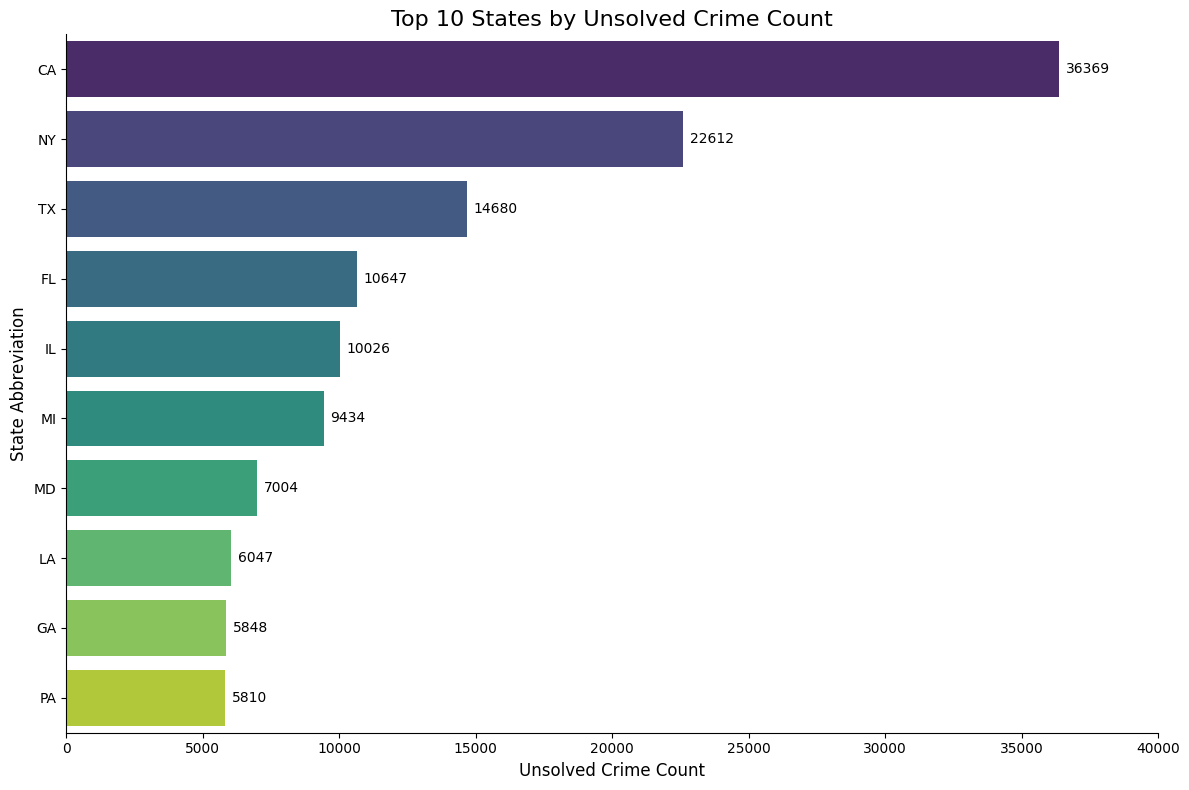

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Sort the unsolved_crimes_by_state DataFrame in descending order and select the top N states (e.g., top 10).
N = 10
top_n_unsolved_states = unsolved_crimes_by_state.sort_values(by='Unsolved_Count', ascending=False).head(N)

plt.figure(figsize=(12, 8))

# 2. Create a bar plot using seaborn.barplot
ax = sns.barplot(
    data=top_n_unsolved_states,
    x='Unsolved_Count',
    y='State_abrr',
    orient='h', # horizontal bar plot
    palette='viridis'
)

# 3. Add labels to the bars showing the exact count of unsolved cases.
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=5)

# 4. Set the x-axis limit from 0 up to an appropriate maximum value with relevant tick intervals
max_count_unsolved = top_n_unsolved_states['Unsolved_Count'].max()
plt.xlim(0, max_count_unsolved * 1.1) # Add some buffer for labels
plt.xticks(np.arange(0, max_count_unsolved * 1.1, 5000)) # ticks every 5000

# 5. Add a title to the plot
plt.title(f'Top {N} States by Unsolved Crime Count', fontsize=16)

# 6. Label the x-axis as 'Unsolved Crime Count' and the y-axis as 'State Abbreviation'.
plt.xlabel('Unsolved Crime Count', fontsize=12)
plt.ylabel('State Abbreviation', fontsize=12)

# 7. Remove the top and right spines of the plot for a cleaner appearance.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 8. Ensure the plot has a tight layout and is displayed.
plt.tight_layout()
plt.show()

#Time Series Analysis

In [72]:
crimes['Date'] = pd.to_datetime(
    crimes['Year'].astype(str) + '-' + crimes['Month'] + '-1',
    format='%Y-%B-%d'
)
crimes

,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source,State_abrr,Date
0,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,...,15.00,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI,AK,1980-01-01
1,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,...,42.00,White,Unknown,Acquaintance,Strangulation,0,0,FBI,AK,1980-03-01
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,...,0.00,Unknown,Unknown,Unknown,Unknown,0,0,FBI,AK,1980-03-01
3,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,...,42.00,White,Unknown,Acquaintance,Strangulation,0,0,FBI,AK,1980-04-01
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,...,0.00,Unknown,Unknown,Unknown,Unknown,0,1,FBI,AK,1980-04-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638449,638450,WY01500,Park County,Sheriff,Park,Wyoming,2014,January,1,Murder or Manslaughter,...,0.00,Unknown,Unknown,Unknown,Handgun,0,0,FBI,WY,2014-01-01
638450,638451,WY01700,Sheridan County,Sheriff,Sheridan,Wyoming,2014,June,1,Murder or Manslaughter,...,57.00,White,Unknown,Acquaintance,Handgun,0,0,FBI,WY,2014-06-01
638451,638452,WY01701,Sheridan,Municipal Police,Sheridan,Wyoming,2014,September,1,Murder or Manslaughter,...,22.00,Asian/Pacific Islander,Unknown,Daughter,Suffocation,0,0,FBI,WY,2014-09-01
638452,638453,WY01800,Sublette County,Sheriff,Sublette,Wyoming,2014,December,1,Murder or Manslaughter,...,31.00,White,Not Hispanic,Stranger,Knife,0,1,FBI,WY,2014-12-01


In [73]:
crimes.set_index('Date', inplace=True)
crimes

,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source,State_abrr
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,...,Male,15.00,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI,AK
1980-03-01,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,...,Male,42.00,White,Unknown,Acquaintance,Strangulation,0,0,FBI,AK
1980-03-01,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,...,Unknown,0.00,Unknown,Unknown,Unknown,Unknown,0,0,FBI,AK
1980-04-01,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,...,Male,42.00,White,Unknown,Acquaintance,Strangulation,0,0,FBI,AK
1980-04-01,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,...,Unknown,0.00,Unknown,Unknown,Unknown,Unknown,0,1,FBI,AK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-01-01,638450,WY01500,Park County,Sheriff,Park,Wyoming,2014,January,1,Murder or Manslaughter,...,Unknown,0.00,Unknown,Unknown,Unknown,Handgun,0,0,FBI,WY
2014-06-01,638451,WY01700,Sheridan County,Sheriff,Sheridan,Wyoming,2014,June,1,Murder or Manslaughter,...,Male,57.00,White,Unknown,Acquaintance,Handgun,0,0,FBI,WY
2014-09-01,638452,WY01701,Sheridan,Municipal Police,Sheridan,Wyoming,2014,September,1,Murder or Manslaughter,...,Female,22.00,Asian/Pacific Islander,Unknown,Daughter,Suffocation,0,0,FBI,WY


In [74]:
import pandas as pd

# ----------------------------
# 1. PREPARE YEARLY COUNTS
# ----------------------------
df = crimes.copy()
df['Year'] = df['Year'].astype(int)

start, end = 1980, 2014
df = df[(df['Year'] >= start) & (df['Year'] <= end)]

# Count incidents per year
yearly = df.groupby('Year').size().rename('Incidents')

# Ensure all years appear
all_years = pd.Index(range(start, end + 1), name='Year')
yearly = yearly.reindex(all_years, fill_value=0).reset_index()

# ----------------------------
# 2. APPLY ROLLING (3-year mean)
# ----------------------------
yearly['Rolling_Incidents'] = yearly['Incidents'].rolling(
    window=3, center=True, min_periods=1
).mean()

# Display the resulting DataFrame
display(yearly.head())

,Year,Incidents,Rolling_Incidents
0,1980,23092,"22,150.00"
1,1981,21208,"21,614.67"
2,1982,20544,"20,468.33"
3,1983,19653,"19,430.00"
4,1984,18093,"18,710.67"


/tmp/ipython-input-2207540469.py:14: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



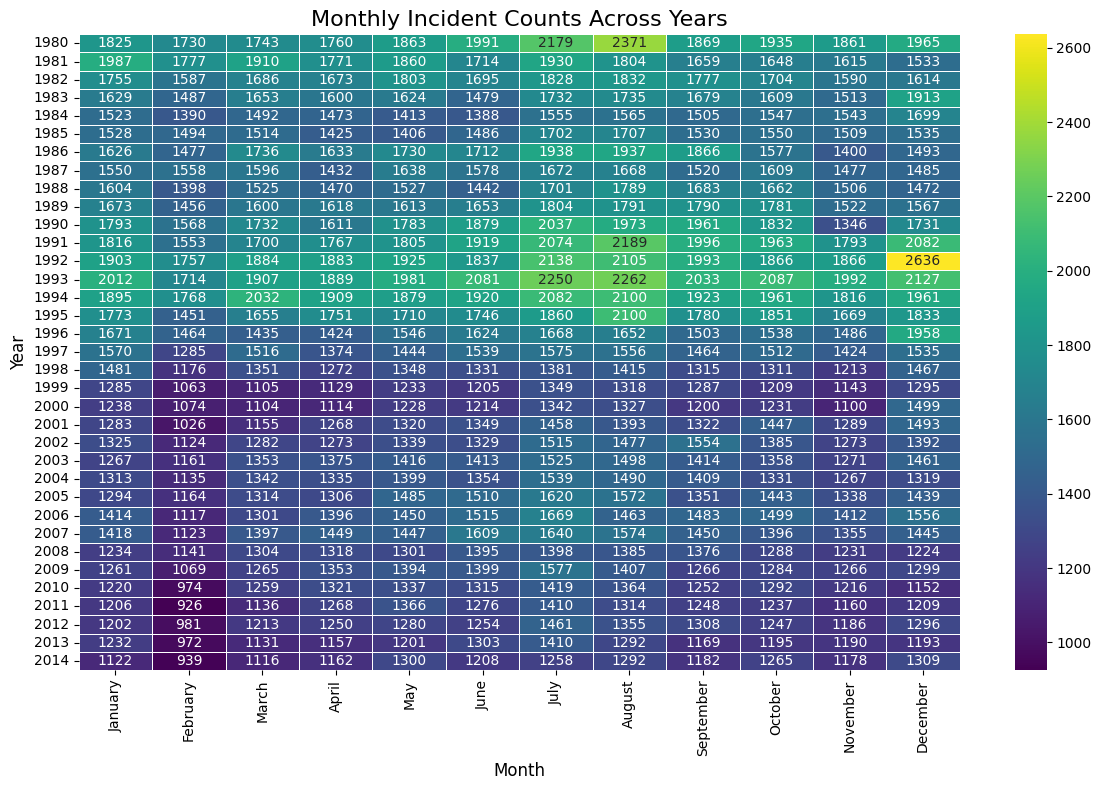

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare monthly incident data
# Make sure 'Month' is ordered correctly for plotting
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
crimes['Month'] = pd.Categorical(crimes['Month'], categories=month_order, ordered=True)

monthly_incidents_by_year = (
    crimes.groupby(['Year', 'Month'])
    .size()
    .reset_index(name='Incident_Count')
)

# 1. Reshape the DataFrame using pivot_table
monthly_pivot = monthly_incidents_by_year.pivot_table(
    index='Year',
    columns='Month',
    values='Incident_Count',
    observed=False # Add this to suppress the FutureWarning
)

# 2. Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    monthly_pivot,
    annot=True, # 3. Add annotations
    fmt='g',    # Format annotations as general numbers
    cmap='viridis', # 4. Set colormap
    linewidths=.5 # Add lines between cells for better separation
)

# 5. Add a title
plt.title('Monthly Incident Counts Across Years', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Year', fontsize=12)

# 6. Ensure the plot is displayed
plt.tight_layout()
plt.show()

In [76]:
import pandas as pd
import numpy as np
import plotly.express as px

df = crimes.copy()
df['Year'] = df['Year'].astype(int)

# Use your known range
df = df[(df['Year'] >= 1980) & (df['Year'] <= 2014)]

# Count incidents per year
yearly = df.groupby('Year').size().reset_index(name='Incidents')

# Ensure no missing years
all_years = pd.Index(range(1980, 2015), name='Year')
yearly = yearly.set_index('Year').reindex(all_years, fill_value=0).reset_index()

In [77]:
yearly['Rolling_Trend'] = yearly['Incidents'].rolling(
    window=3,        # smooths short-term spikes
    center=True,
    min_periods=1
).mean()

In [78]:
fig = px.line(
    yearly,
    x='Year',
    y=['Incidents', 'Rolling_Trend'],
    markers=True,
    title='Yearly Crime Incidents with Rolling Trend (1980–2014)'
)

fig.update_traces(
    line=dict(width=2),
    hovertemplate='Year: %{x}<br>Value: %{y}<extra></extra>'
)

fig.update_layout(
    yaxis_title='Number of Incidents',
    xaxis_title='Year',
    template='plotly_white',
    hovermode='x unified'
)

fig.show()

## Identify Autocorrelation in Incident Data

### Subtask:
Calculate and plot the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) for the incident data.


**Reasoning**:
To calculate and plot the ACF and PACF, I need to import the `plot_acf` and `plot_pacf` functions from `statsmodels.graphics.tsaplots`.



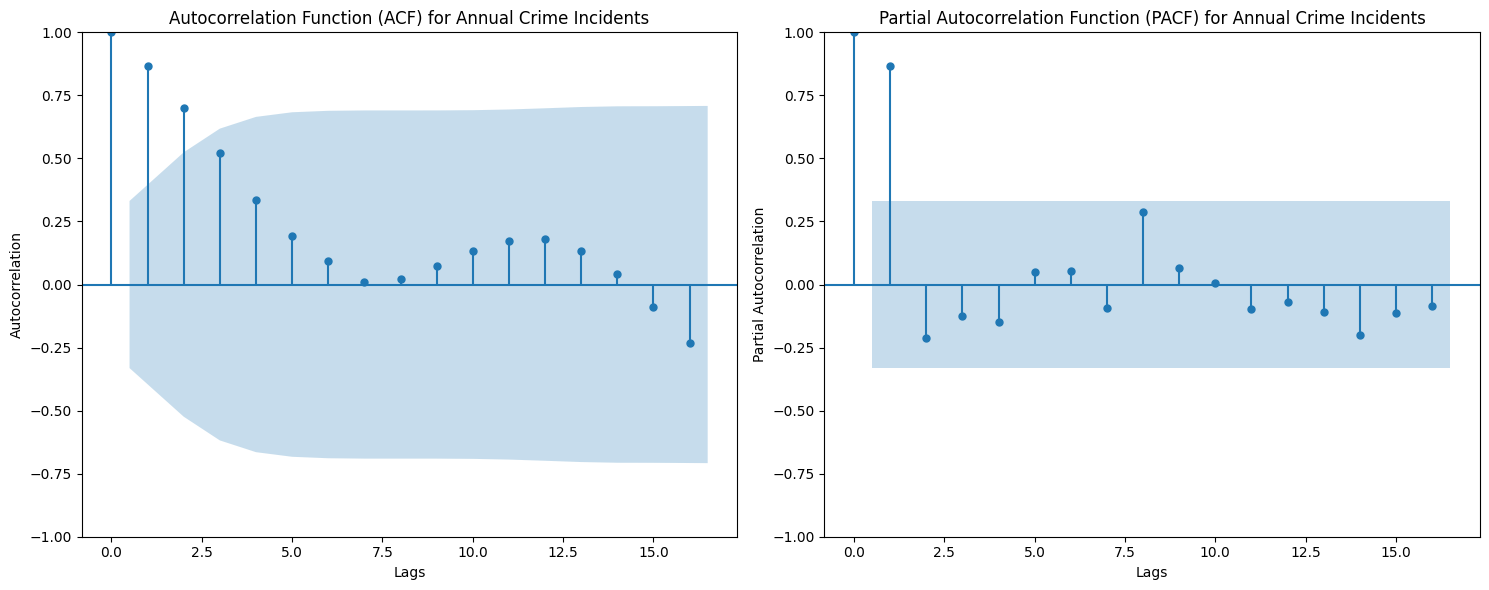

In [79]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot ACF on the first subplot
plot_acf(yearly['Incidents'], ax=axes[0], lags=len(yearly) // 2 - 1)
axes[0].set_title('Autocorrelation Function (ACF) for Annual Crime Incidents')
axes[0].set_xlabel('Lags')
axes[0].set_ylabel('Autocorrelation')

# Plot PACF on the second subplot
plot_pacf(yearly['Incidents'], ax=axes[1], lags=len(yearly) // 2 - 1)
axes[1].set_title('Partial Autocorrelation Function (PACF) for Annual Crime Incidents')
axes[1].set_xlabel('Lags')
axes[1].set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()

# Task
Aggregate the count of each 'Crime Type' by year from the `crimes` DataFrame, unstack the 'Crime Type' column to create separate columns for each crime type, and fill any missing values with zeros to prepare the data for time series analysis.

## Prepare Data for 'Crime Type' TSA

### Subtask:
Aggregate the count of each 'Crime Type' by year.


In [80]:
crime_type_yearly = (
    crimes.groupby(['Year', 'Crime Type'])
    .size()
    .unstack(fill_value=0)
)

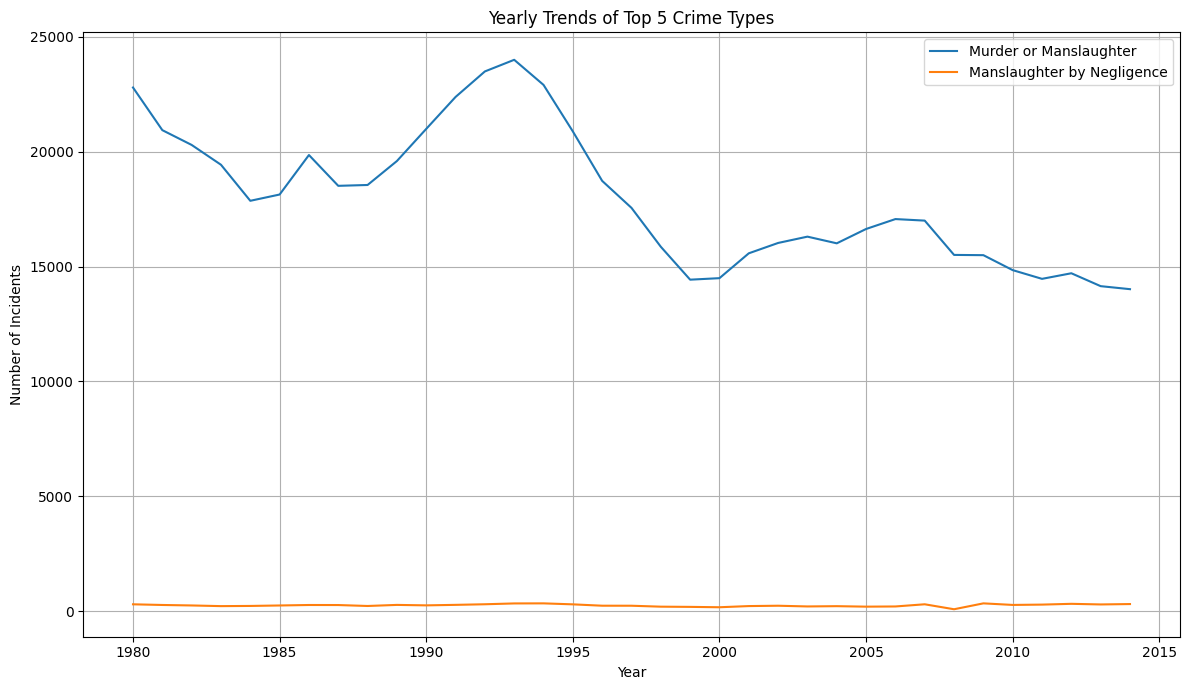

In [81]:
import matplotlib.pyplot as plt

# 1. Identify the top 5 most frequent crime types
top_5_crime_types = crime_type_yearly.sum().nlargest(5).index

# 2. Create a line plot for these top 5 crime types over time (Year)
plt.figure(figsize=(12, 7))
for crime_type in top_5_crime_types:
    plt.plot(crime_type_yearly.index, crime_type_yearly[crime_type], label=crime_type)

# 3. Label the x-axis as 'Year' and the y-axis as 'Number of Incidents'
plt.xlabel('Year')
plt.ylabel('Number of Incidents')

# 4. Add a title to the plot
plt.title('Yearly Trends of Top 5 Crime Types')

# 5. Add a legend to differentiate between crime types
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

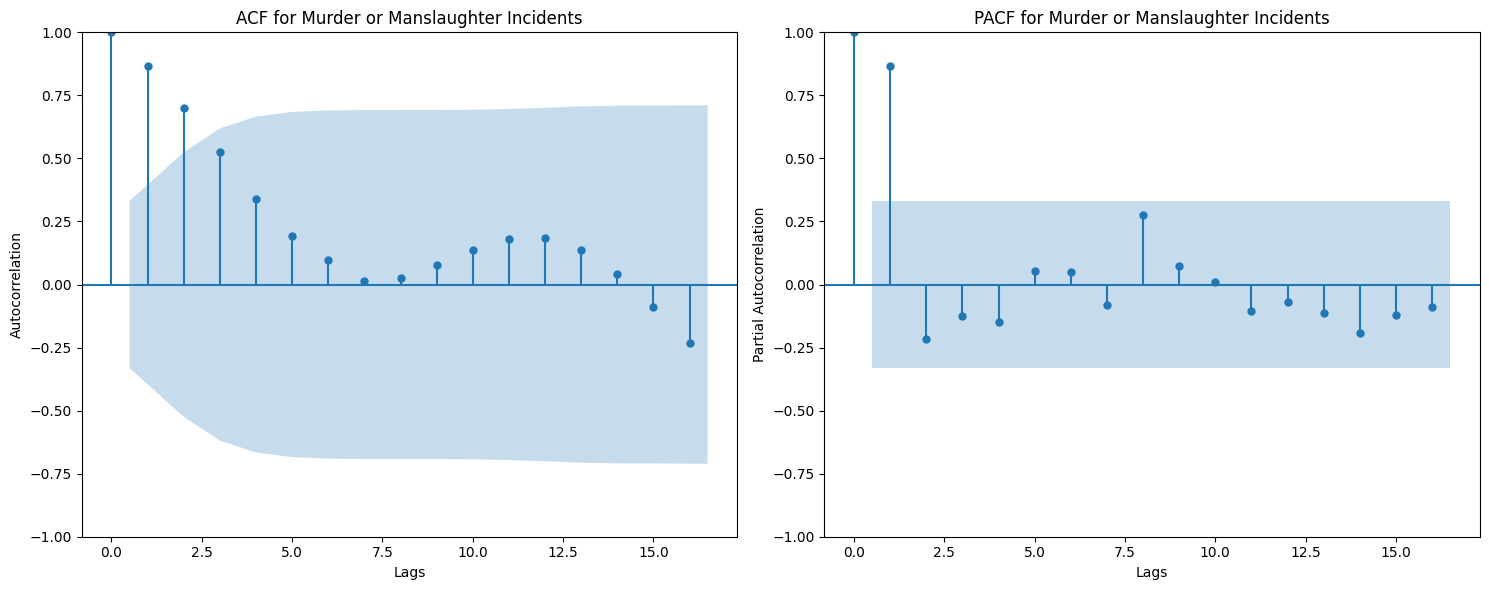

In [82]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 6. Create a figure with two subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 7. Plot ACF for 'Murder or Manslaughter'
plot_acf(crime_type_yearly['Murder or Manslaughter'], ax=axes[0], lags=len(crime_type_yearly) // 2 - 1)
axes[0].set_title('ACF for Murder or Manslaughter Incidents')
axes[0].set_xlabel('Lags')
axes[0].set_ylabel('Autocorrelation')

# 8. Plot PACF for 'Murder or Manslaughter'
plot_pacf(crime_type_yearly['Murder or Manslaughter'], ax=axes[1], lags=len(crime_type_yearly) // 2 - 1)
axes[1].set_title('PACF for Murder or Manslaughter Incidents')
axes[1].set_xlabel('Lags')
axes[1].set_ylabel('Partial Autocorrelation')

# 9. Ensure both plots have appropriate lag values and 10. Display both plots
plt.tight_layout()
plt.show()

## Prepare Data for 'Crime Solved' TSA

### Subtask:
Aggregate the count of 'Solved' and 'Unsolved' crimes by year, unstack 'Crime Solved' to create separate columns, and fill missing values with zeros.


In [83]:
crime_solved_yearly = (
    crimes.groupby(['Year', 'Crime Solved'])
    .size()
    .unstack(fill_value=0)
)

display(crime_solved_yearly.head())

Crime Solved,No,Yes
Year,,
1980,6363,16729
1981,5420,15788
1982,5484,15060
1983,5138,14515
1984,4848,13245


## Visualize and Analyze 'Crime Solved' Yearly Trends



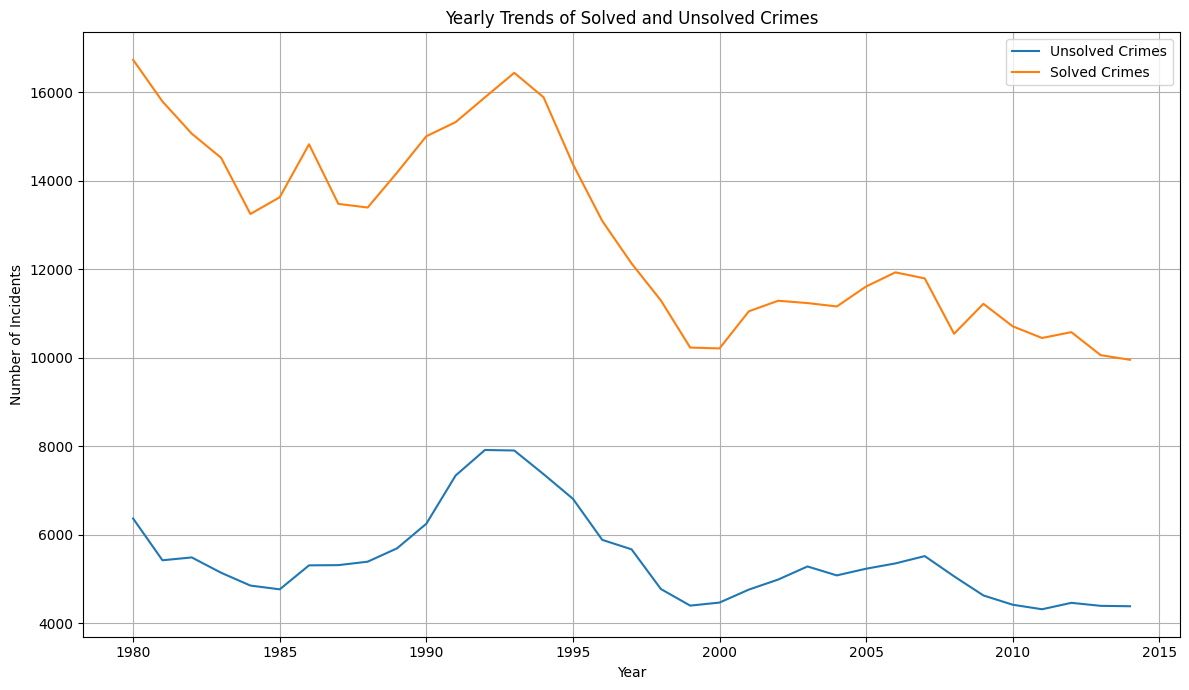

In [84]:
import matplotlib.pyplot as plt

# 1. Create a line plot for the 'No' (unsolved) and 'Yes' (solved) crime incidents over time (Year)
plt.figure(figsize=(12, 7))
plt.plot(crime_solved_yearly.index, crime_solved_yearly['No'], label='Unsolved Crimes')
plt.plot(crime_solved_yearly.index, crime_solved_yearly['Yes'], label='Solved Crimes')

# Label the x-axis as 'Year' and the y-axis as 'Number of Incidents'
plt.xlabel('Year')
plt.ylabel('Number of Incidents')

# Add a title to the plot
plt.title('Yearly Trends of Solved and Unsolved Crimes')

# Add a legend to differentiate between solved and unsolved incidents
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

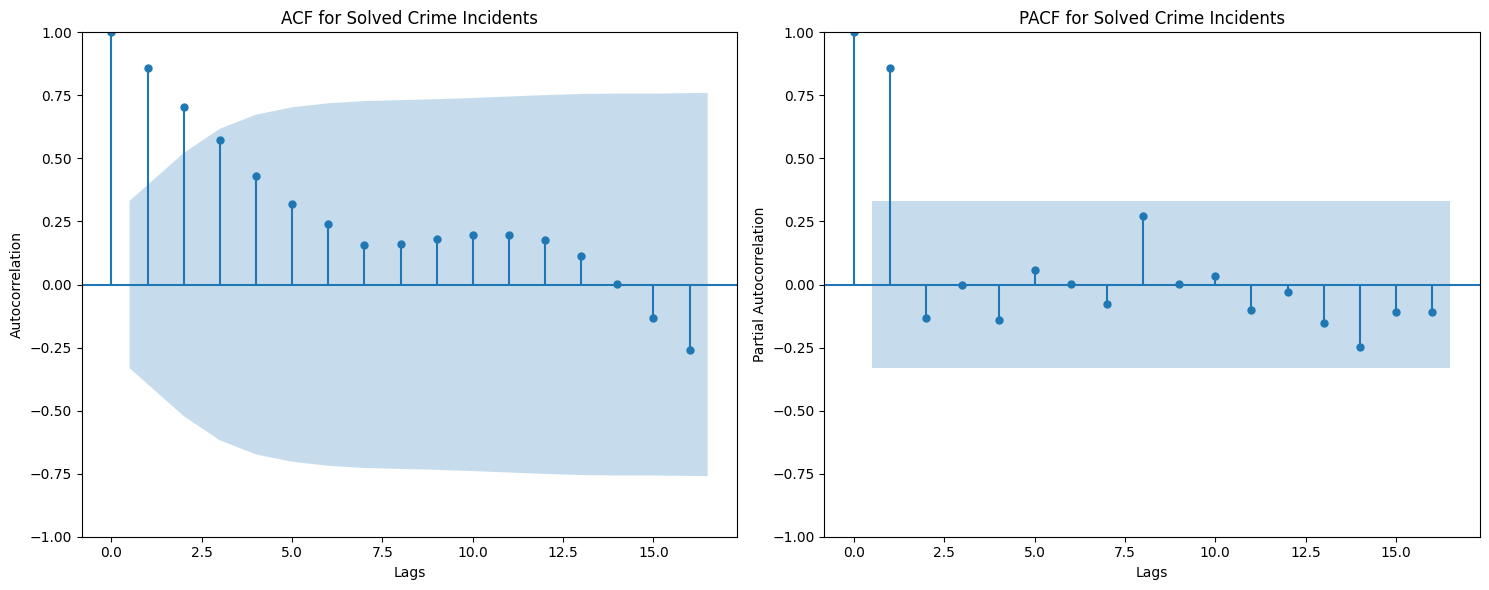

In [85]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 2. Create a figure with two subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 3. Plot the Autocorrelation Function (ACF) on the first subplot for the 'Yes' column
plot_acf(crime_solved_yearly['Yes'], ax=axes[0], lags=len(crime_solved_yearly) // 2 - 1)
axes[0].set_title('ACF for Solved Crime Incidents')
axes[0].set_xlabel('Lags')
axes[0].set_ylabel('Autocorrelation')

# 4. Plot the Partial Autocorrelation Function (PACF) on the second subplot for the 'Yes' column
plot_pacf(crime_solved_yearly['Yes'], ax=axes[1], lags=len(crime_solved_yearly) // 2 - 1)
axes[1].set_title('PACF for Solved Crime Incidents')
axes[1].set_xlabel('Lags')
axes[1].set_ylabel('Partial Autocorrelation')

# 5. Ensure both plots are displayed with a tight layout
plt.tight_layout()
plt.show()

## Prepare Data for 'Victim Count' TSA



In [86]:
import pandas as pd

# 1. Create a copy of the crimes DataFrame
df_victim_count = crimes.copy()

# Ensure 'Year' is an integer type for proper filtering
df_victim_count['Year'] = df_victim_count['Year'].astype(int)

# 2. Filter the DataFrame to include data only for years between 1980 and 2014
start_year, end_year = 1980, 2014
df_victim_count = df_victim_count[
    (df_victim_count['Year'] >= start_year) &
    (df_victim_count['Year'] <= end_year)
]

# 3. Group the filtered DataFrame by 'Year' and sum the 'Victim Count'
victim_count_yearly = (
    df_victim_count.groupby('Year')['Victim Count']
    .sum()
    .rename('Victim_Count')
)

# 4. Create a pandas.Index containing all years from 1980 to 2014
all_years = pd.Index(range(start_year, end_year + 1), name='Year')

# 5. Reindex victim_count_yearly using the complete list of years, filling any missing years with a 0 victim count
victim_count_yearly = (
    victim_count_yearly.reindex(all_years, fill_value=0)
    .reset_index()
)

# Display the resulting DataFrame
display(victim_count_yearly.head())

,Year,Victim_Count
0,1980,2410
1,1981,2118
2,1982,2692
3,1983,1950
4,1984,2110


## Prepare Data for 'Perpetrator Count' TSA



In [87]:
import pandas as pd

# 1. Create a copy of the crimes DataFrame
df_perpetrator_count = crimes.copy()

# 2. Ensure 'Year' is an integer type for proper filtering
df_perpetrator_count['Year'] = df_perpetrator_count['Year'].astype(int)

# 3. Filter the DataFrame to include data only for years between 1980 and 2014
start_year, end_year = 1980, 2014
df_perpetrator_count = df_perpetrator_count[
    (df_perpetrator_count['Year'] >= start_year) &
    (df_perpetrator_count['Year'] <= end_year)
]

# 4. Group the filtered DataFrame by 'Year' and sum the 'Perpetrator Count'
perpetrator_count_yearly = (
    df_perpetrator_count.groupby('Year')['Perpetrator Count']
    .sum()
    .rename('Perpetrator_Count')
)

# 5. Create a pandas.Index containing all years from 1980 to 2014
all_years = pd.Index(range(start_year, end_year + 1), name='Year')

# 6. Reindex perpetrator_count_yearly using the complete list of years,
#    filling any missing years with a 0 perpetrator count. Convert to DataFrame and reset index.
perpetrator_count_yearly = (
    perpetrator_count_yearly.reindex(all_years, fill_value=0)
    .reset_index()
)

# 7. Display the resulting DataFrame
display(perpetrator_count_yearly.head())

,Year,Perpetrator_Count
0,1980,4237
1,1981,2823
2,1982,2879
3,1983,2604
4,1984,2438


## Visualize and Analyze 'Victim Count' Yearly Trends


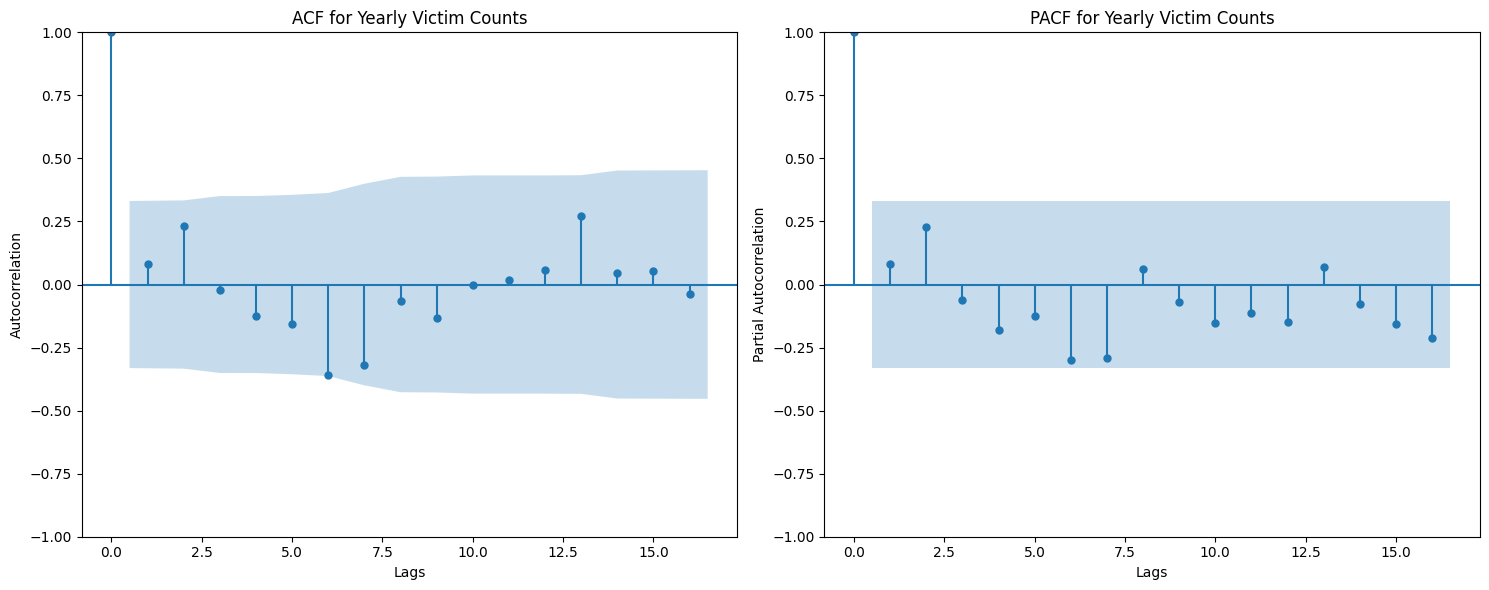

In [88]:
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1. Calculate the 3-year centered rolling mean
victim_count_yearly['Rolling_Victim_Count'] = (
    victim_count_yearly['Victim_Count'].rolling(
        window=3, center=True, min_periods=1
    ).mean()
)

# 2. Create an interactive line plot for Victim Count and Rolling Mean
fig_line = px.line(
    victim_count_yearly,
    x='Year',
    y=['Victim_Count', 'Rolling_Victim_Count'],
    markers=True,
    title='Yearly Victim Counts with 3-Year Rolling Mean (1980–2014)'
)

# 3. Update the line plot traces
fig_line.update_traces(
    line=dict(width=2),
    hovertemplate='Year: %{x}<br>Value: %{y}<extra></extra>'
)

# 4. Update the layout of the line plot
fig_line.update_layout(
    yaxis_title='Number of Victims',
    xaxis_title='Year',
    template='plotly_white',
    hovermode='x unified'
)

fig_line.show()

# 5. Create a figure with two subplots for ACF and PACF
fig_acf_pacf, axes = plt.subplots(1, 2, figsize=(15, 6))

# 6. Plot the Autocorrelation Function (ACF)
plot_acf(
    victim_count_yearly['Victim_Count'],
    ax=axes[0],
    lags=len(victim_count_yearly) // 2 - 1
)
axes[0].set_title('ACF for Yearly Victim Counts')
axes[0].set_xlabel('Lags')
axes[0].set_ylabel('Autocorrelation')

# 7. Plot the Partial Autocorrelation Function (PACF)
plot_pacf(
    victim_count_yearly['Victim_Count'],
    ax=axes[1],
    lags=len(victim_count_yearly) // 2 - 1
)
axes[1].set_title('PACF for Yearly Victim Counts')
axes[1].set_xlabel('Lags')
axes[1].set_ylabel('Partial Autocorrelation')

# 8. Ensure a tight layout and display plots
plt.tight_layout()
plt.show()

## Visualize and Analyze 'Perpetrator Count' Yearly Trends


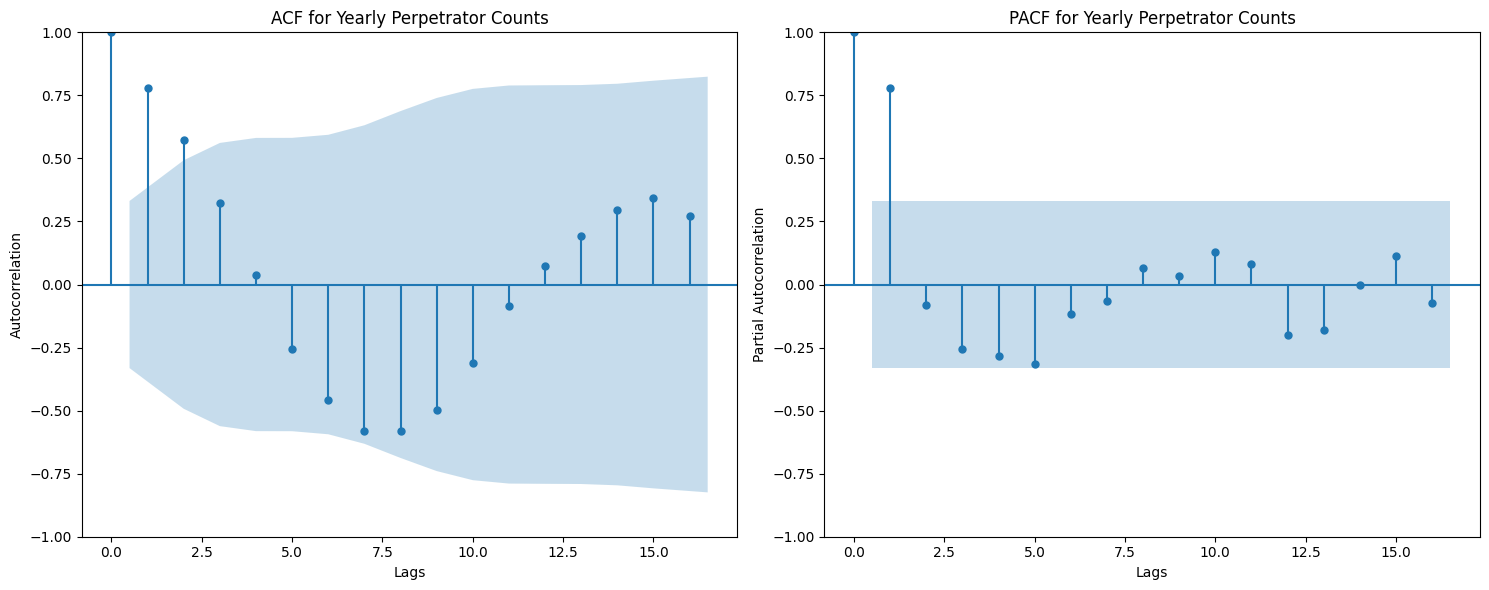

In [89]:
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1. Calculate the 3-year centered rolling mean
perpetrator_count_yearly['Rolling_Perpetrator_Count'] = (
    perpetrator_count_yearly['Perpetrator_Count'].rolling(
        window=3, center=True, min_periods=1
    ).mean()
)

# 2. Create an interactive line plot for Perpetrator Count and Rolling Mean
fig_line = px.line(
    perpetrator_count_yearly,
    x='Year',
    y=['Perpetrator_Count', 'Rolling_Perpetrator_Count'],
    markers=True,
    title='Yearly Perpetrator Counts with 3-Year Rolling Mean (1980–2014)'
)

# 3. Update the line plot traces
fig_line.update_traces(
    line=dict(width=2),
    hovertemplate='Year: %{x}<br>Value: %{y}<extra></extra>'
)

# 4. Update the layout of the line plot
fig_line.update_layout(
    yaxis_title='Number of Perpetrators',
    xaxis_title='Year',
    template='plotly_white',
    hovermode='x unified'
)

# 5. Display the interactive line plot
fig_line.show()

# 6. Create a figure with two subplots for ACF and PACF
fig_acf_pacf, axes = plt.subplots(1, 2, figsize=(15, 6))

# 7. Plot the Autocorrelation Function (ACF)
plot_acf(
    perpetrator_count_yearly['Perpetrator_Count'],
    ax=axes[0],
    lags=len(perpetrator_count_yearly) // 2 - 1
)
axes[0].set_title('ACF for Yearly Perpetrator Counts')
axes[0].set_xlabel('Lags')
axes[0].set_ylabel('Autocorrelation')

# 8. Plot the Partial Autocorrelation Function (PACF)
plot_pacf(
    perpetrator_count_yearly['Perpetrator_Count'],
    ax=axes[1],
    lags=len(perpetrator_count_yearly) // 2 - 1
)
axes[1].set_title('PACF for Yearly Perpetrator Counts')
axes[1].set_xlabel('Lags')
axes[1].set_ylabel('Partial Autocorrelation')

# 9. Ensure a tight layout and display plots
plt.tight_layout()
plt.show()